# Introduction

---


In today's global marketplace, understanding corporate ownership structures is crucial for businesses, investors, and regulators. Companies operate within complex parent-child relationships across domestic and international borders. Identifying whether a company is a "Domestic Ultimate" or a "Global Ultimate" reveals insights into its autonomy, global reach, and decision-making power.

This report explores the development of a Machine Learning Model aimed at accurately predicting whether a company is classified as a "Domestic Ultimate" or "Global Ultimate", based on its operational, financial, and structural characteristics. Ultimately, the model's ability to predict corporate structure seeks to provide actionable insights to assist in competitive analysis, investment strategies, and merger & acquisition decisions.


# Setting Up

---


To start off, the necessary libraries to handle data manipulation, visualisation, and machine learning tasks, were imported.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import lightgbm as lgb
import tensorflow as tf
import statsmodels.api as sm
import random

# Data Cleaning

---



## Loading and Preparing of Dataset
After loading the dataset, we dropped 2 columns as per question requirements.

In [ ]:
df = pd.read_csv('Champions_Group_2025.csv')
df = df.drop(['Parent Company', 'Parent Country'], axis=1)  # Exclude columns

## Excluding Irrelevant Columns by Eye
We assessed the relevance of the remaining features. For those that do not seem to contribute meaningfully to our analysis, their removal is justified in the following table.
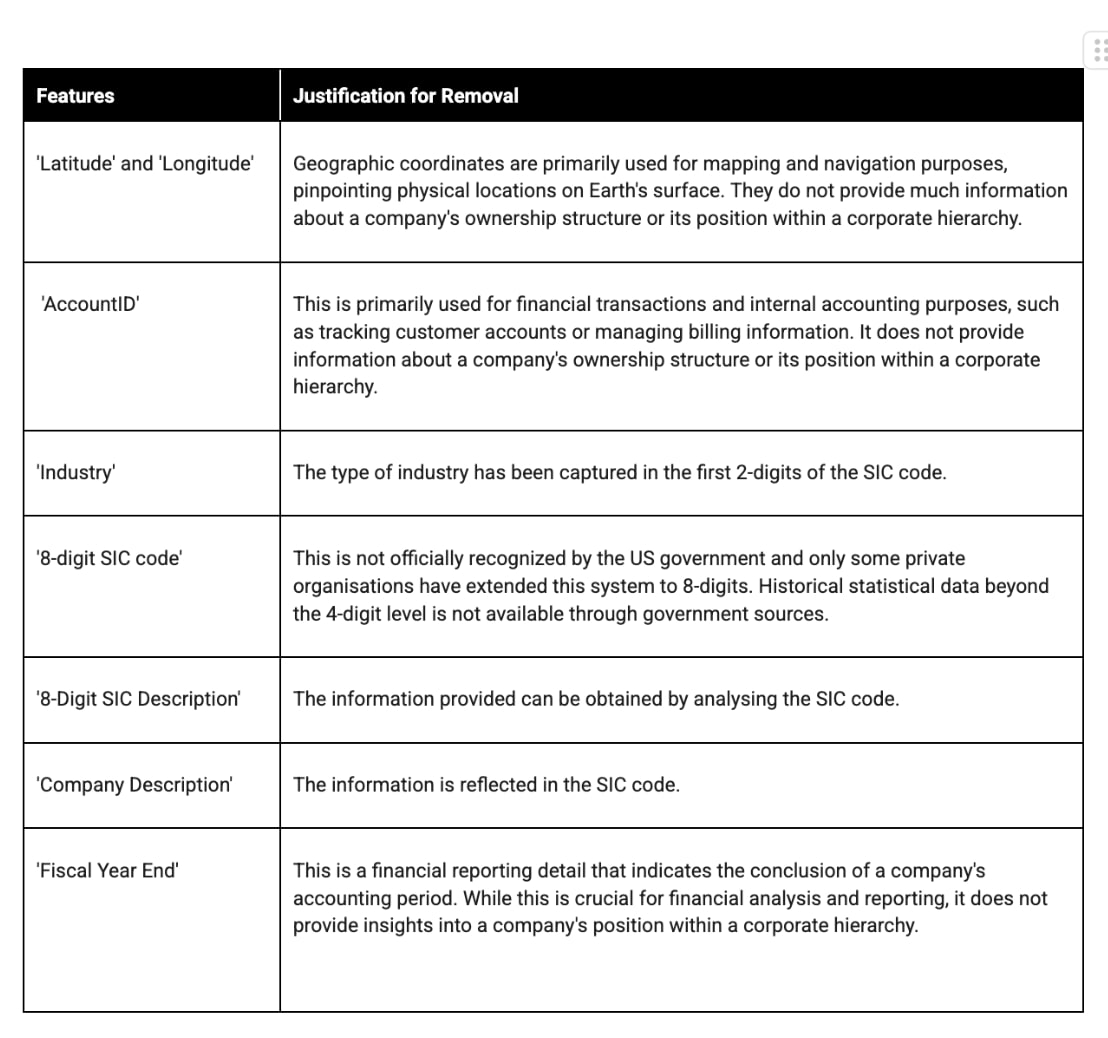

In [ ]:
df = df.drop(['LATITUDE', 'LONGITUDE', 'AccountID', 'Industry', '8-Digit SIC Code', '8-Digit SIC Description', 'Fiscal Year End', 'Company Description'], axis=1)

## Checking for Missing Values
Next, we examine the percentage of missing values in each column, which is important for the following reasons.

1. Ensure Data Integrity.                                                  
   Identifying and addressing missing values helps maintain the accuracy and completeness of your dataset, which is vital for building trustworthy models.

2. Prevent Algorithmic Errors.  
   Many machine learning algorithms require complete datasets. Unaddressed missing values can cause algorithms to fail or produce incorrect outputs.

3. Avoid Bias.  
   If missing data is not handled properly, it can introduce bias into your analysis, leading to misleading conclusions.


A heatmap can first be leveraged to visualise the missing data. 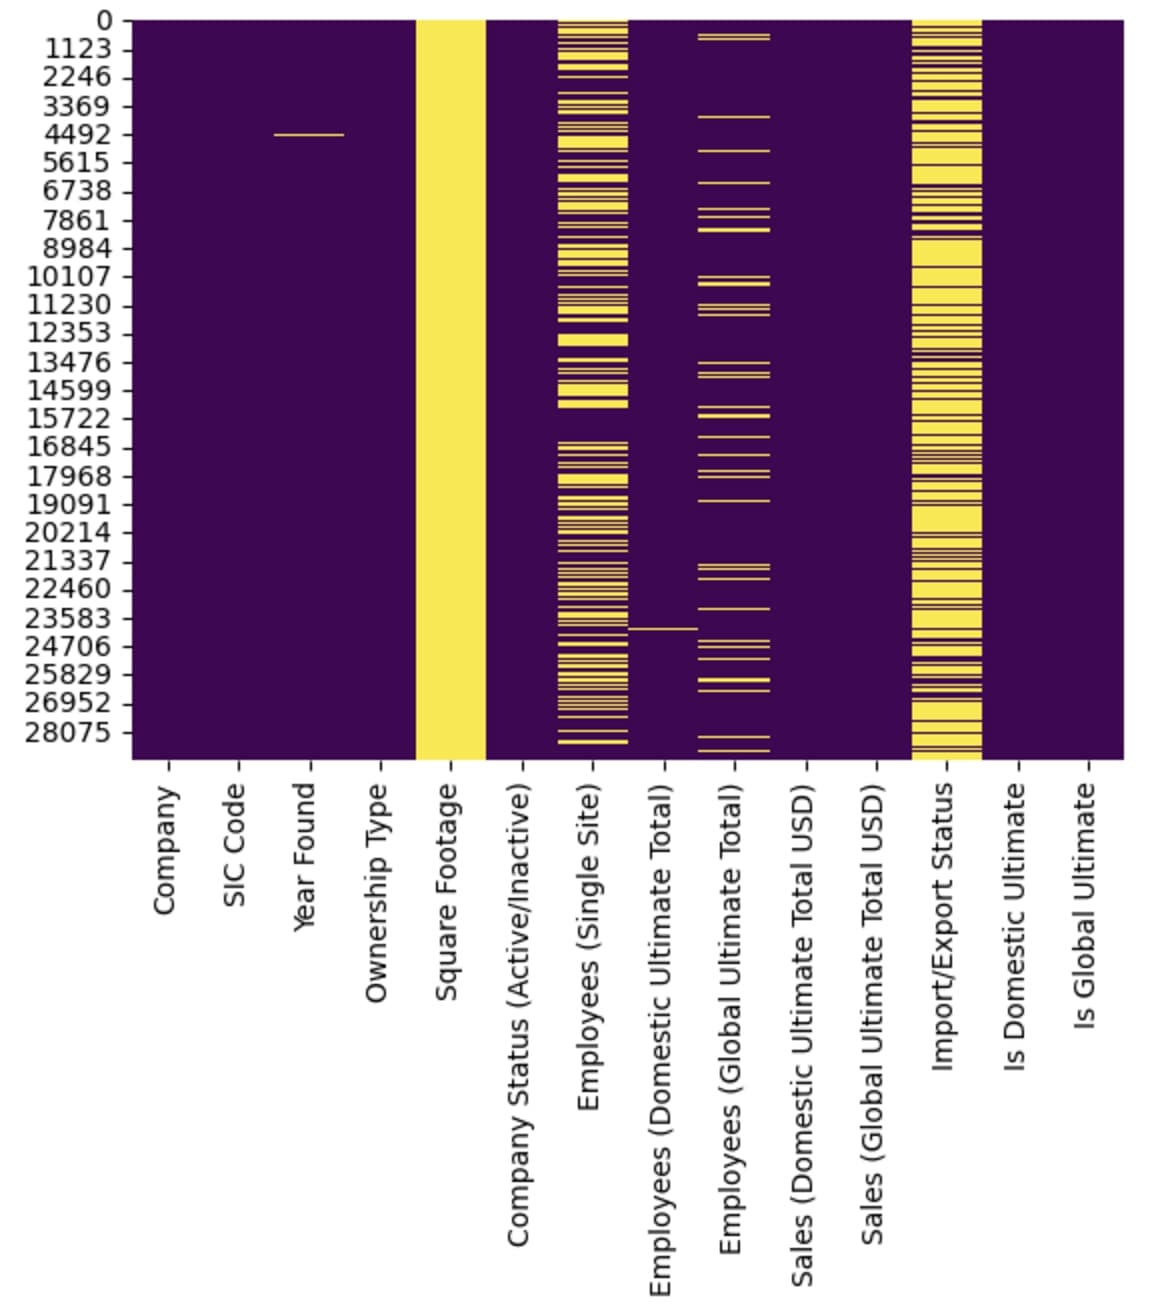

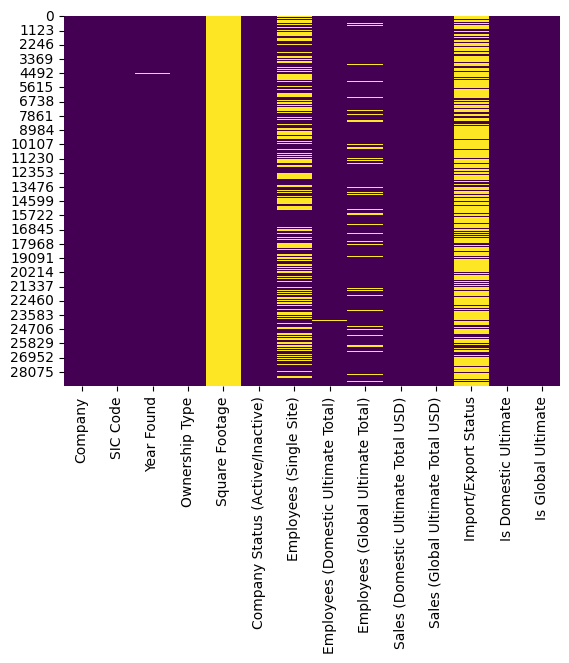

In [ ]:
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.show()

Then, we can programmatically identify the missing data.

In [ ]:
print(df.isna().sum() / len(df))

Company                                0.000000
SIC Code                               0.000000
Year Found                             0.014872
Ownership Type                         0.000000
Square Footage                         1.000000
Company Status (Active/Inactive)       0.000000
Employees (Single Site)                0.425022
Employees (Domestic Ultimate Total)    0.002707
Employees (Global Ultimate Total)      0.095059
Sales (Domestic Ultimate Total USD)    0.000000
Sales (Global Ultimate Total USD)      0.000000
Import/Export Status                   0.773388
Is Domestic Ultimate                   0.000000
Is Global Ultimate                     0.000000
dtype: float64


Examining the percentages, we observed three features with relatively high levels of NaN values.

1. 'Square Footage' contains no data at all (all NA values).

2. 'Import/Export Status' has the next highest percentage of NA values (more than 50%). While this indicator would have been highly informative in assessing a company's scale, we cannot assume that the NA values indicate a complete absence of trade, and these missing values may very well stem from incomplete reporting or other data collection issues.  

3. Almost half of the 'Employees (Single Site)' are NA values (42.5%). Although we could fill in missing values Mean or Median Imputation, removing this feature entirely is unlikely to have significant effect on our predictions, as there does not does not appear to be a strong, direct correlation between the number of employees at a particular site and the overall scale of a company. Ultimately, features that capture the overall size and reach of companies, both domestically and globally, such as total domestic or global employees would provide more meaningful insights.

Hence, these three features were removed.

In [ ]:
df.isna().sum() / len(df)
df = df.drop(['Import/Export Status', 'Square Footage', 'Employees (Single Site)'], axis=1)

## Handling Duplicates
We should eliminate duplicate entries in the 'Company' column so as to maintain data integrity and accuracy. Otherwise, duplicate records may distort information, leading to inconsistencies and erroneous predictions, undermining the model's performance and reliability.

**Since our test returned `False`, there was no need to exclude duplicated companies.**

Then, we deleted the Company column since company name was deemed irrelevant to its Ultimate status.

In [ ]:
df.duplicated(subset=['Company']).any()
df = df.drop('Company', axis=1)

## Removing Irrelevant Columns upon further Data Analysis

All companies' activity status were assessed, as inactive companies do not yield insights into whether they are classified as global or domestic ultimate entities.

Since our evaluation confirmed that all companies are active, 'Company Status (Active/Inactive)' was entirely removed from the dataset.

In [ ]:
df['Company Status (Active/Inactive)'].unique()
df = df.drop('Company Status (Active/Inactive)', axis=1)

## One-Hot Encoding on Categorical Variables
For non-numeric categorical variables such as 'Ownership Type', one-hot encoding is necessary because most machine learning models require numerical input for effective processing. Even though '2-digit SIC Code' appears to be numeric, it is actually a categorical variable representing industry classifications rather than continuous or ordinal data. This makes one-hot encoding useful for representing the distinct categories without imposing a misleading ordinal relationship between them.

For example, a '2-digit SIC Code' might represent:

1. 20: Food and Kindred Products
2. 35: Industrial and Commercial Machinery
3. 50: Wholesale Trade - Durable Goods

If these codes were treated as continuous numeric values, our model might incorrectly assume that SIC Code 50 is somehow twice of SIC Code 25. One-hot encoding prevents this issue by creating binary columns for each unique SIC code, allowing the model to learn associations for each category independently without introducing spurious correlations based on numeric magnitude.

In [ ]:
from sklearn.preprocessing import OneHotEncoder
# one-hot encoding 'Ownership Type'
print(df['Ownership Type'].unique())
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_data = encoder.fit_transform(df[['Ownership Type']])
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['Ownership Type']))
df = pd.concat([df, encoded_df], axis=1)
df = df.drop('Ownership Type', axis=1)

# one-hot encoding '2-digit SIC Code'
df = df.dropna(subset=['SIC Code'])
df['2-digit SIC Code'] = df[['SIC Code']] // 100

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_data = encoder.fit_transform(df[['2-digit SIC Code']])
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['2-digit SIC Code']))
df = pd.concat([df, encoded_df], axis=1)
df = df.drop(['SIC Code', '2-digit SIC Code'], axis=1)

['Private' 'Public' 'Non-Corporates' 'Partnership' 'Public Sector'
 'Nonprofit']


##Removing Rows with Null Values in Key Columns

As mentioned earlier, retaining incomplete records could lead to bias or distortion in the analysis, as missing data can obscure or skew relationships between variables. As such, we removed rows with missing values for features with some NA values, specifically 'Year Found', 'Employees (Domestic Ultimate Total)', and 'Employees (Global Ultimate Total)'. By excluding these rows, we can ensure that the analysis reflects the most accurate representation of the companies' histories, scales, and their effects on predictions.

In [ ]:
df = df.dropna(subset=['Year Found', 'Employees (Domestic Ultimate Total)', 'Employees (Global Ultimate Total)'])

## Ensuring Numeric Values
We used the pd.to_numeric() function to convert certain columns to numeric types. The errors='coerce' parameter ensures that any non-numeric values are converted to NaN (Not a Number) without causing errors. To assess the proportion of missing (NaN) values in each column, we applied df.isna(), which returns a DataFrame of the same shape as df, with True for NaN values and False otherwise. By using .sum(), we count the number of NaN values in each column, and dividing by len(df) (the total number of rows) converts these counts into proportions. We used these proportions to evaluate the extent of missing data in each column.

In [ ]:
df.loc[:, 'Employees (Domestic Ultimate Total)'] = pd.to_numeric(df['Employees (Domestic Ultimate Total)'], errors='coerce')
df.loc[:, 'Employees (Global Ultimate Total)'] = pd.to_numeric(df['Employees (Global Ultimate Total)'], errors='coerce')
df.loc[:, 'Sales (Global Ultimate Total USD)'] = pd.to_numeric(df['Sales (Global Ultimate Total USD)'], errors='coerce')
df.loc[:, 'Sales (Domestic Ultimate Total USD)'] = pd.to_numeric(df['Sales (Domestic Ultimate Total USD)'], errors='coerce')
df.isna().sum() / len(df)

df.head()

Year Found  Employees (Domestic Ultimate Total)  \
0      1980.0                                300.0   
1      1993.0                                100.0   
2      2018.0                                 22.0   
3      2004.0                                100.0   
4      1986.0                                 33.0   

   Employees (Global Ultimate Total)  Sales (Domestic Ultimate Total USD)  \
0                              300.0                             76973100   
1                              100.0                              9499251   
2                               22.0                             13738494   
3                              100.0                            103745791   
4                               33.0                             60863682   

   Sales (Global Ultimate Total USD)  Is Domestic Ultimate  \
0                           76973100                     0   
1                            9499251                     0   
2                           13738494                     0   
3                          103745791                     0   
4                           60863682                     1   

   Is Global Ultimate  Ownership Type_Non-Corporates  \
0                   0                            0.0   
1                   0                            0.0   
2                   0                            0.0   
3                   0                            0.0   
4                   1                            0.0   

   Ownership Type_Nonprofit  Ownership Type_Partnership  ...  \
0                       0.0                         0.0  ...   
1                       0.0                         0.0  ...   
2                       0.0                         0.0  ...   
3                       0.0                         0.0  ...   
4                       0.0                         0.0  ...   

   2-digit SIC Code_83  2-digit SIC Code_84  2-digit SIC Code_86  \
0                  0.0                  0.0                  0.0   
1                  0.0                  0.0                  0.0   
2                  0.0                  0.0                  0.0   
3                  0.0                  0.0                  0.0   
4                  0.0                  0.0                  0.0   

   2-digit SIC Code_87  2-digit SIC Code_89  2-digit SIC Code_91  \
0                  0.0                  0.0                  0.0   
1                  0.0                  0.0                  0.0   
2                  0.0                  0.0                  0.0   
3                  0.0                  0.0                  0.0   
4                  0.0                  0.0                  0.0   

   2-digit SIC Code_92  2-digit SIC Code_93  2-digit SIC Code_96  \
0                  0.0                  0.0                  0.0   
1                  0.0                  0.0                  0.0   
2                  0.0                  0.0                  0.0   
3                  0.0                  0.0                  0.0   
4                  0.0                  0.0                  0.0   

   2-digit SIC Code_97  
0                  0.0  
1                  0.0  
2                  0.0  
3                  0.0  
4                  0.0  

[5 rows x 88 columns]

In reality, global sales, which includes domestic sales, should either be equal to or more than domestic sales. However, there are a few instances where this was not the case. As such, we carried out the following steps.
1. We identified and quantified the instances where global sales are less than domestic sales, calculating the proportion of such cases within the dataset.
2. We filtered the dataset to retain only the rows where global sales meet or exceed domestic sales.

This would ensure a more reliable and logical representation of the data.

In [ ]:
num_rows = (df['Sales (Global Ultimate Total USD)'] < df['Sales (Domestic Ultimate Total USD)']).sum()  # Count rows where A < B
total_rows = len(df)  # Total number of rows
proportion = num_rows / total_rows  # Compute proportion

print(f"Rows where A < B: {num_rows}/{total_rows} ({proportion:.2%})")
df = df[df['Sales (Global Ultimate Total USD)'] >= df['Sales (Domestic Ultimate Total USD)']]

# Check the new size of the DataFrame
print(f"New number of rows: {len(df)}")

Rows where A < B: 1834/25985 (7.06%)
New number of rows: 24151


## Visualizing Employee Distribution
The distribution of 'Employees (Domestic Ultimate Total)' was visualised through a histogram to better understand the data's characteristics.

Upon examination, we observed that the data is significantly right-skewed, indicating the presence of extreme high values.

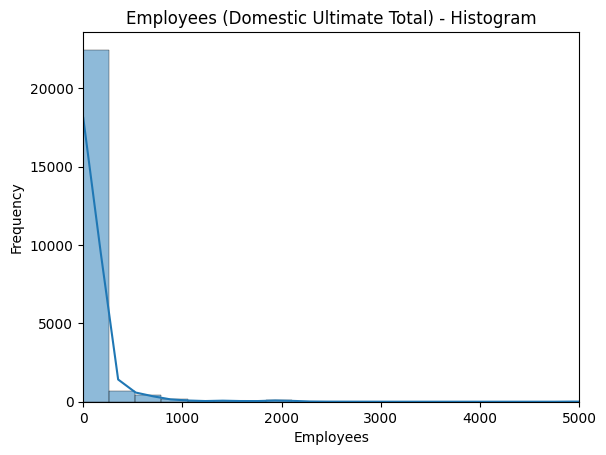

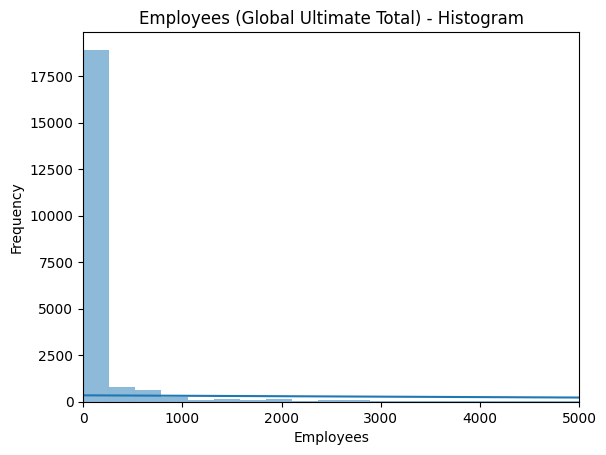

In [ ]:
bins = np.linspace(0, 5000, 20)

sns.histplot(df['Employees (Domestic Ultimate Total)'], bins=bins, kde=True)
plt.title('Employees (Domestic Ultimate Total) - Histogram')
plt.xlabel('Employees')
plt.ylabel('Frequency')
plt.xlim(0, 5000)
plt.show()

sns.histplot(df['Employees (Global Ultimate Total)'], bins=bins, kde=True)
plt.title('Employees (Global Ultimate Total) - Histogram')
plt.xlabel('Employees')
plt.ylabel('Frequency')
plt.xlim(0, 5000)
plt.show()

\
To address this skewness, we decided to manage these extremely high values, as they appear unrealistic. A review of several companies revealed that their employee counts do not match the inflated figures reflected in the dataset. By filtering out these outliers, we aim to enhance the accuracy and reliability of our analysis, ensuring that the insights derived are more representative of typical employee distributions... **(YULUN + why are we not using Box Plot instead)**

In [ ]:
def remove_outliers(df, columns):
    # Initialize a boolean mask for all rows (True = keep, False = remove)
    mask = pd.Series(True, index=df.index)

    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        upper_bound = Q3 + 3 * (Q3 - Q1)

        # Update the mask to exclude outliers in the current column
        mask &= (df[column] >= 0) & (df[column] <= upper_bound)

    # Apply the final mask to filter the DataFrame
    filtered_df = df[mask]

    # Check the new size of the DataFrame
    print(f"New number of rows: {len(filtered_df)}")
    return filtered_df

# List of columns to check for outliers
columns_to_check = [
    'Employees (Domestic Ultimate Total)',
    'Employees (Global Ultimate Total)',
    'Sales (Global Ultimate Total USD)',
    'Sales (Domestic Ultimate Total USD)'
]

# Remove outliers considering all columns together
df = remove_outliers(df, columns_to_check)

# Log-transform the specified columns (avoid taking log of zero or negative values)
columns_to_log_transform = [
    'Employees (Domestic Ultimate Total)',
    'Employees (Global Ultimate Total)',
    'Sales (Domestic Ultimate Total USD)',
    'Sales (Global Ultimate Total USD)'
]

# Apply log transformation
for column in columns_to_log_transform:
    df[column] = np.log1p(df[column])

New number of rows: 16966


<ipython-input-218-2c80c9b24e8b>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = np.log1p(df[column])


## Visualising Class Imbalances


Visualising class imbalances is important to identify bias in the dataset.
If one class significantly outnumbers the other, the model might favor the majority class, leading to poor generalisation for the minority class.

In this case, less than 5% of companies are Global Ultimate (meaning that more than 95% of companies are not Global Ultimate). If no data balancing techniques are employed, our predictive model is likely to achieve approximately 95% accuracy by predicting the majority class, but it will be futile in detecting "Global Ultimate" companies.

Therefore, we will be employing Synthetic Minority Over-sampling Technique (SMOTE) to generate synthetic samples for the minority class 'Is Not Global Ultimate' using k-nearest neighbors (KNN) during the Model Training process later on.

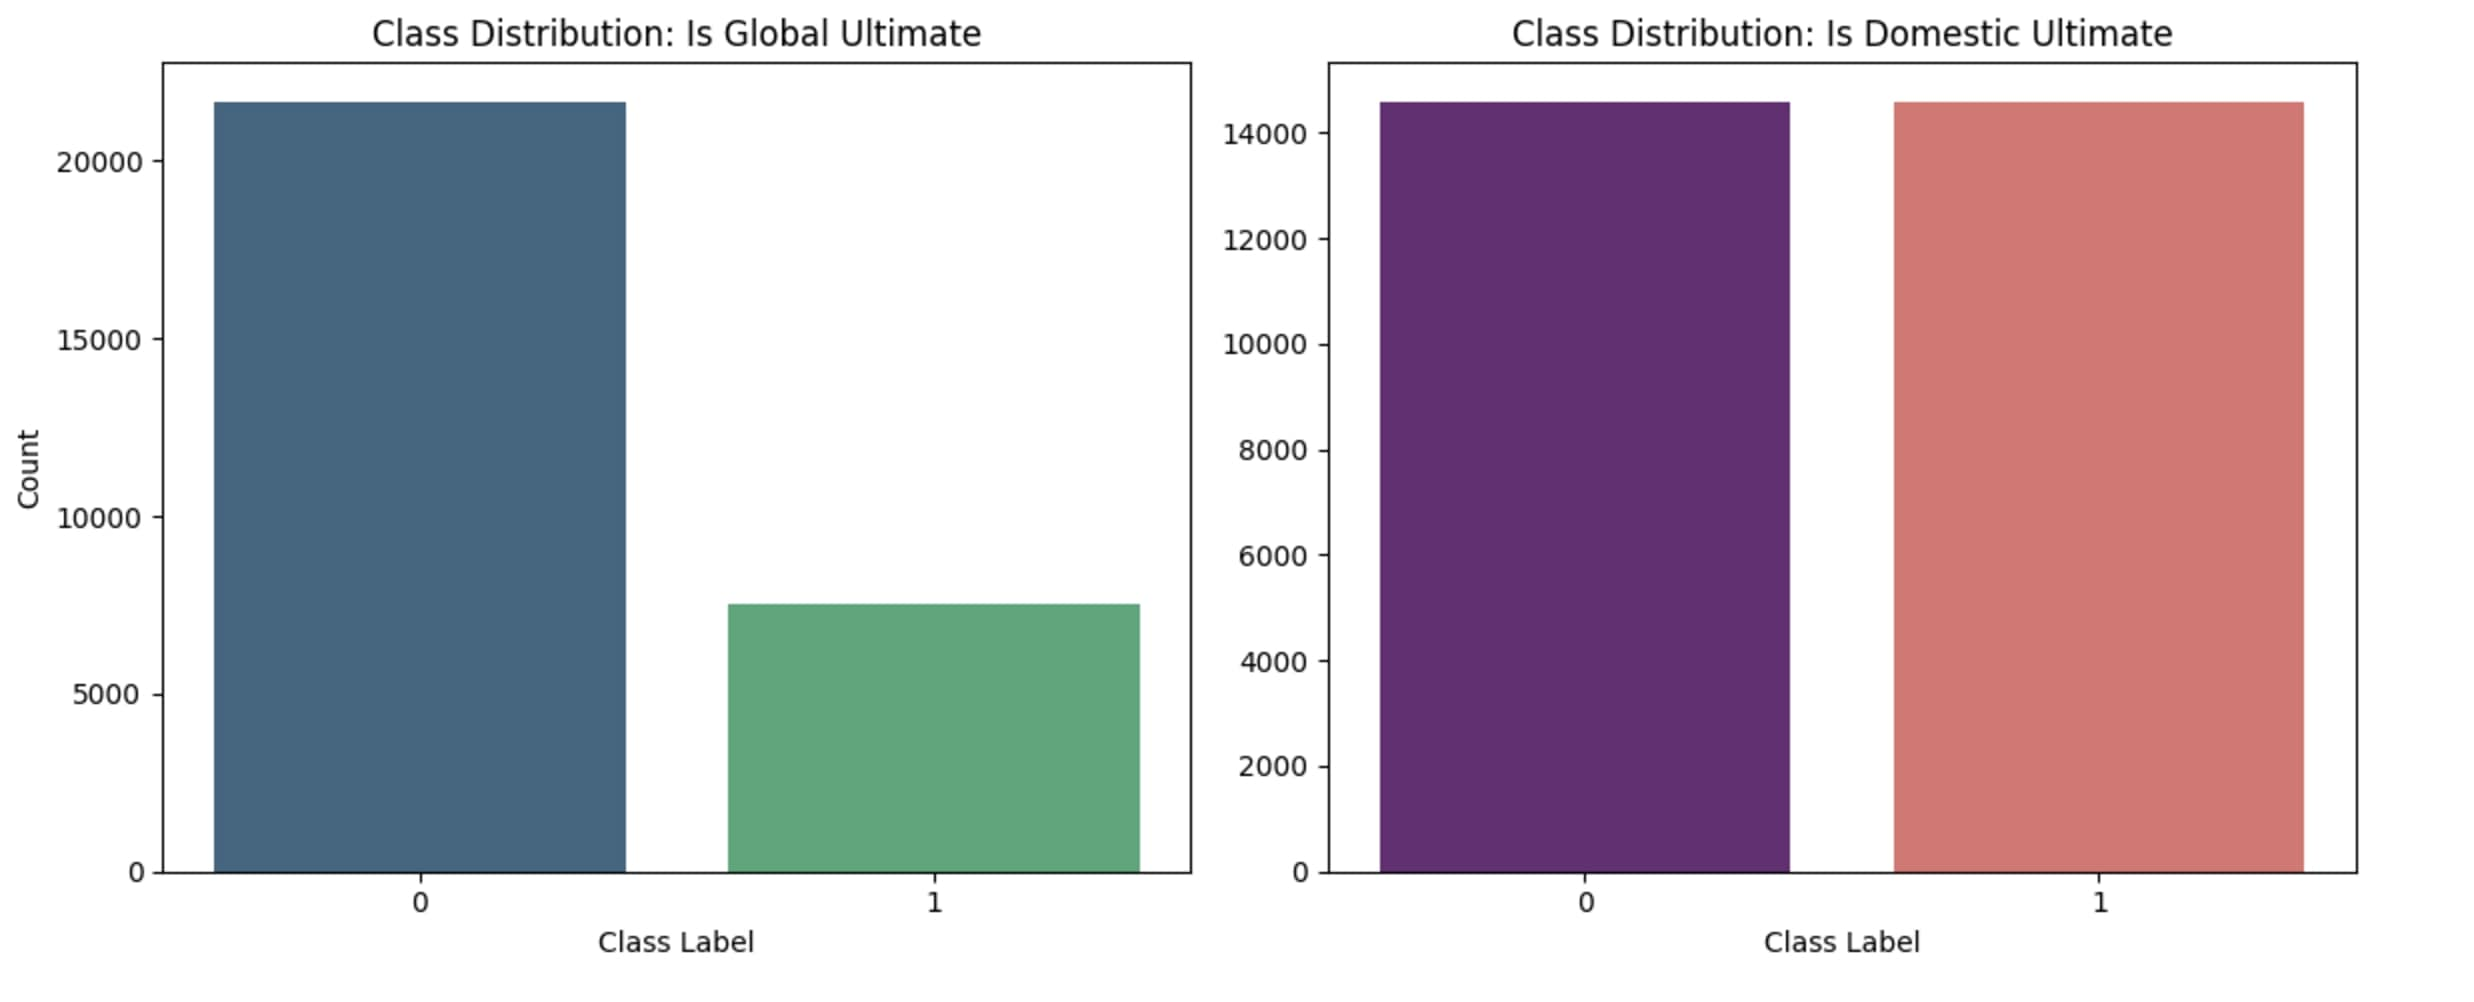

<ipython-input-219-c7d9498afd27>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df['Is Global Ultimate'].value_counts().index,
<ipython-input-219-c7d9498afd27>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df['Is Domestic Ultimate'].value_counts().index,


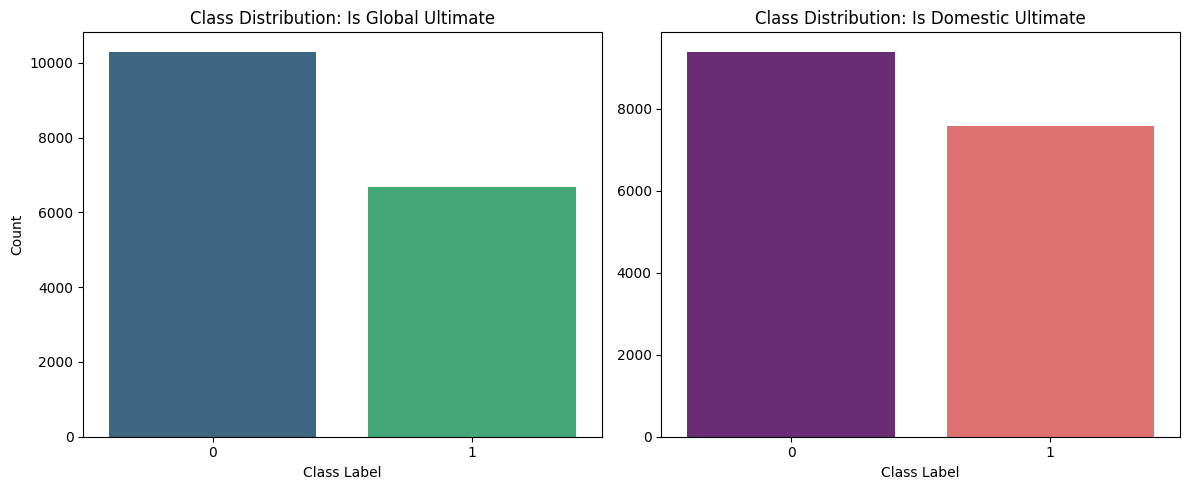

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot for 'Is Global Ultimate'
sns.barplot(x=df['Is Global Ultimate'].value_counts().index,
            y=df['Is Global Ultimate'].value_counts().values,
            palette="viridis", ax=axes[0])
axes[0].set_title("Class Distribution: Is Global Ultimate")
axes[0].set_xlabel("Class Label")
axes[0].set_ylabel("Count")

# Plot for 'Is Domestic Ultimate'
sns.barplot(x=df['Is Domestic Ultimate'].value_counts().index,
            y=df['Is Domestic Ultimate'].value_counts().values,
            palette="magma", ax=axes[1])
axes[1].set_title("Class Distribution: Is Domestic Ultimate")
axes[1].set_xlabel("Class Label")

plt.tight_layout()
plt.show()

# Uncovering Patterns in the Cleaned Dataset Using Unsupervised Learning
---
We started with Unsupervised Learning Techniques to uncover hidden patterns or groupings in the cleaned data before moving on to Supervised Learning Techniques. This approach was chosen because using a high number of features directly in supervised models could lead to issues such as overfitting, high computation time, and model complexity. Unsupervised learning would then offer an opportunity to reduce dimensionality and identify the most important underlying features before training more complex supervised models.

We considered 3 types of Unsupervised Learning Techniques in this process, all of which requiring X to be scaled.


In [ ]:
X = df.drop(columns=['Is Global Ultimate', 'Is Domestic Ultimate'])  # Exclude target columns
X = X.iloc[:, 1:]  # Select all columns except the first one

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert scaled data back to a pandas DataFrame with original feature names
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

## K-means Clustering
K-means was the first technique considered.

However, we deemed that it was unsuitable for our dataset due to the fact that Euclidean distance is used as the measure of similarity. This measure requires variables to be continuous, as Euclidean distance computes the direct spatial distance between data points. Since most of our variables were categorical, K-means is unlikely able to meaningfully assess similarity between points.

Nevertheless, we attempted to conduct K-means for variables such as 'Employees (Domestic Ultimate Total)', 'Employees (Global Ultimate Total)',
               'Sales (Domestic Ultimate Total USD)', 'Sales (Global Ultimate Total USD)'

But no clear elbow point was found, and we did not find a clear way to cluster our data. Moreover, experiments where we included k-means data seemed to worsen model performance, leading us to exclude k-means clusters from our built dataset.

Clusters: 2, Inertia: 25865.24, Silhouette Score: 0.5984
Clusters: 3, Inertia: 23693.23, Silhouette Score: 0.5611
Clusters: 4, Inertia: 17828.37, Silhouette Score: 0.5229
Clusters: 5, Inertia: 13336.45, Silhouette Score: 0.5588
Clusters: 6, Inertia: 10610.18, Silhouette Score: 0.5589
Clusters: 7, Inertia: 9531.70, Silhouette Score: 0.5469
Clusters: 8, Inertia: 8372.35, Silhouette Score: 0.5569
Clusters: 9, Inertia: 7887.65, Silhouette Score: 0.5594
Clusters: 10, Inertia: 7293.11, Silhouette Score: 0.5636


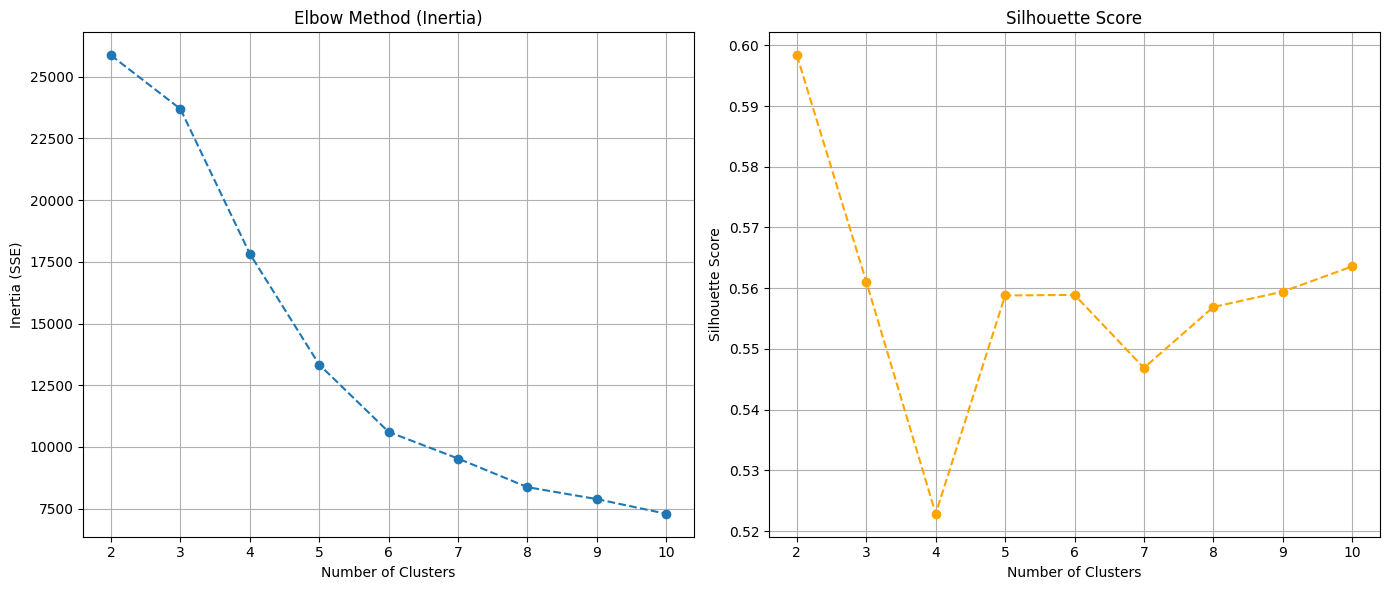

In [ ]:
features = df[['Employees (Domestic Ultimate Total)', 'Employees (Global Ultimate Total)',
               'Sales (Domestic Ultimate Total USD)', 'Sales (Global Ultimate Total USD)']]
# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Initialize lists to store evaluation metrics
inertia = []
silhouette_scores = []
cluster_range = range(2, 11)  # Start from 2 clusters for silhouette score

# Perform KMeans clustering for each number of clusters and evaluate
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)  # Using standardized features

    # Inertia (Elbow Method)
    inertia.append(kmeans.inertia_)

    # Silhouette Score
    labels = kmeans.labels_
    score = silhouette_score(scaled_features, labels)
    silhouette_scores.append(score)

    print(f"Clusters: {k}, Inertia: {kmeans.inertia_:.2f}, Silhouette Score: {score:.4f}")

# Plot Elbow Method (Inertia)
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(cluster_range, inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (SSE)')
plt.title('Elbow Method (Inertia)')
plt.grid(True)

# Plot Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(cluster_range, silhouette_scores, marker='o', linestyle='--', color='orange')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score')
plt.grid(True)

plt.tight_layout()
plt.show()

## Hierarchical Clustering
Next, we experimented with Hierarchical Clustering, specifically using Complete Linkage as the dissimilarity measure. This approach attempts to ensure more balanced clusters by considering the maximum distance between data points in different clusters.

However, the resulting dendrogram still appeared elongated and imbalanced, resembling the results of Single Linkage (which considers the minimum distance between points in different clusters). This indicated that the clustering did not produce clear, actionable groupings, making it difficult to identify meaningful categories for subsequent analysis.

Moreover, this model is highly-time consuming in terms of its run time, and takes up too much RAM too. Therefore, we deemed this technique as unsuitable.

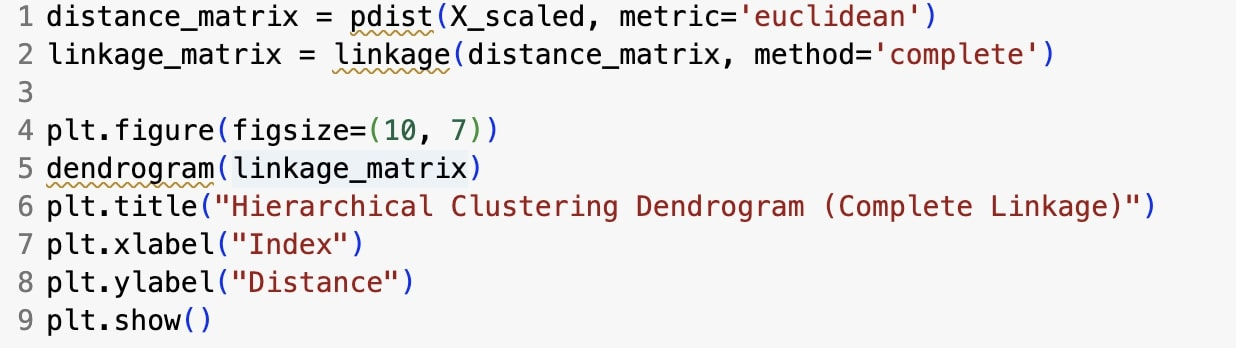

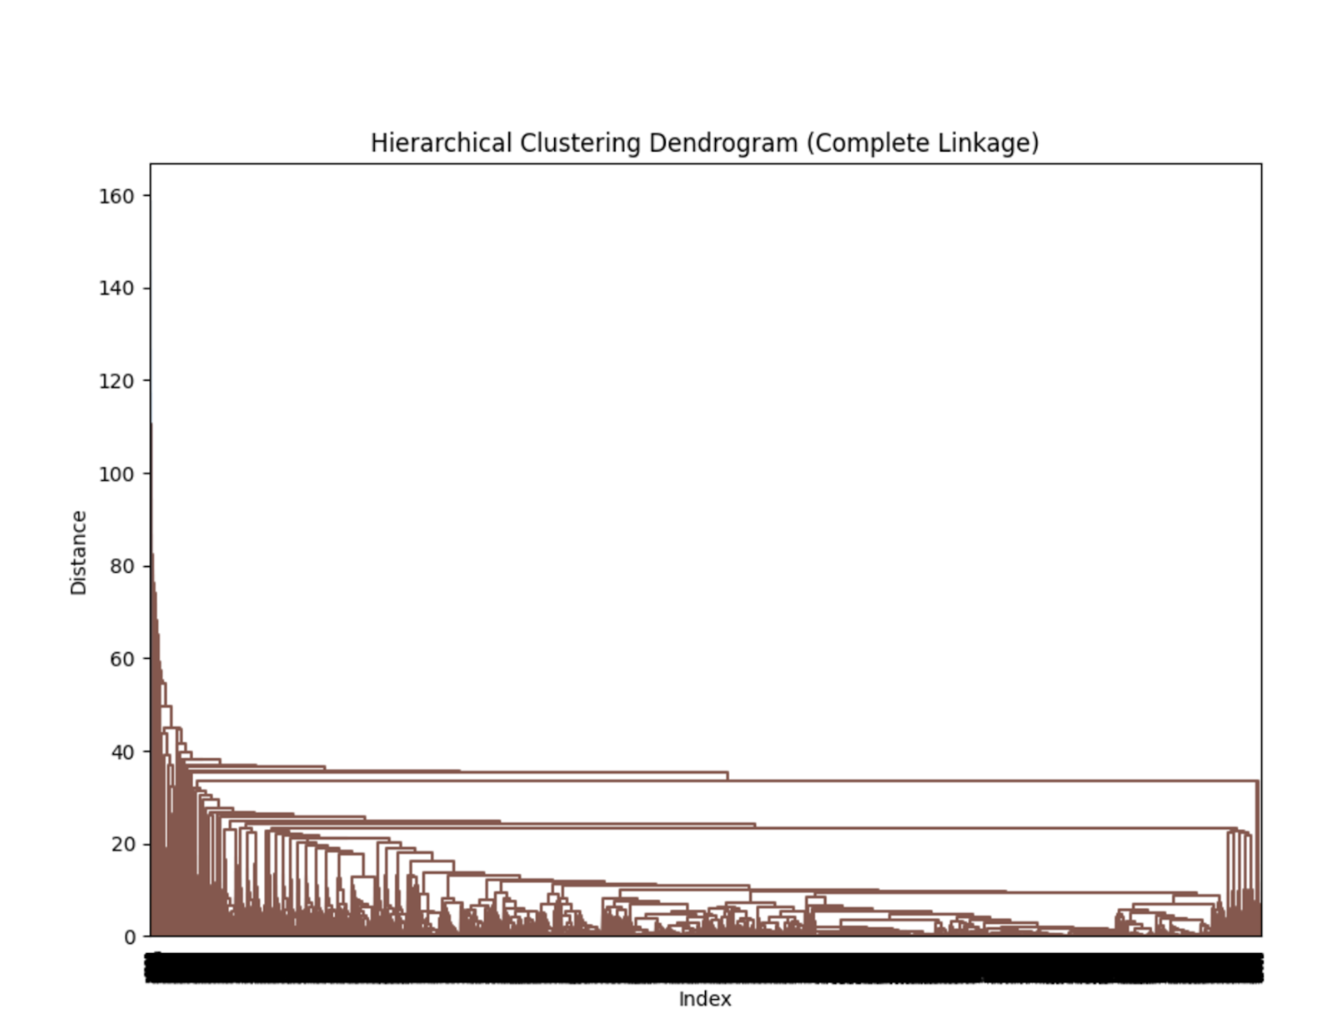

## Principal Component Analysis (PCA)
Given the challenges faced with clustering techniques, we proceeded with Principal Component Analysis (PCA), with the goal of reduce the dimensionality of the dataset for better model efficiency and interpretability without losing key information. This helped reduce the number of features while retaining the most meaningful variance in the dataset.

To check for multicollinearity between features in our dataset (as PCA works better when features are highly correlated), a correlation matrix was plotted. The matrix reveals signficant correlation between the employee numbers and the sales figures, perhaps because these columns are all correlated with company size.

There is also some correlation between Ownership Types columns. This motivated us to conduct Principle Component Analysis and include PCs that account for higher percentages of variance in our training dataset.

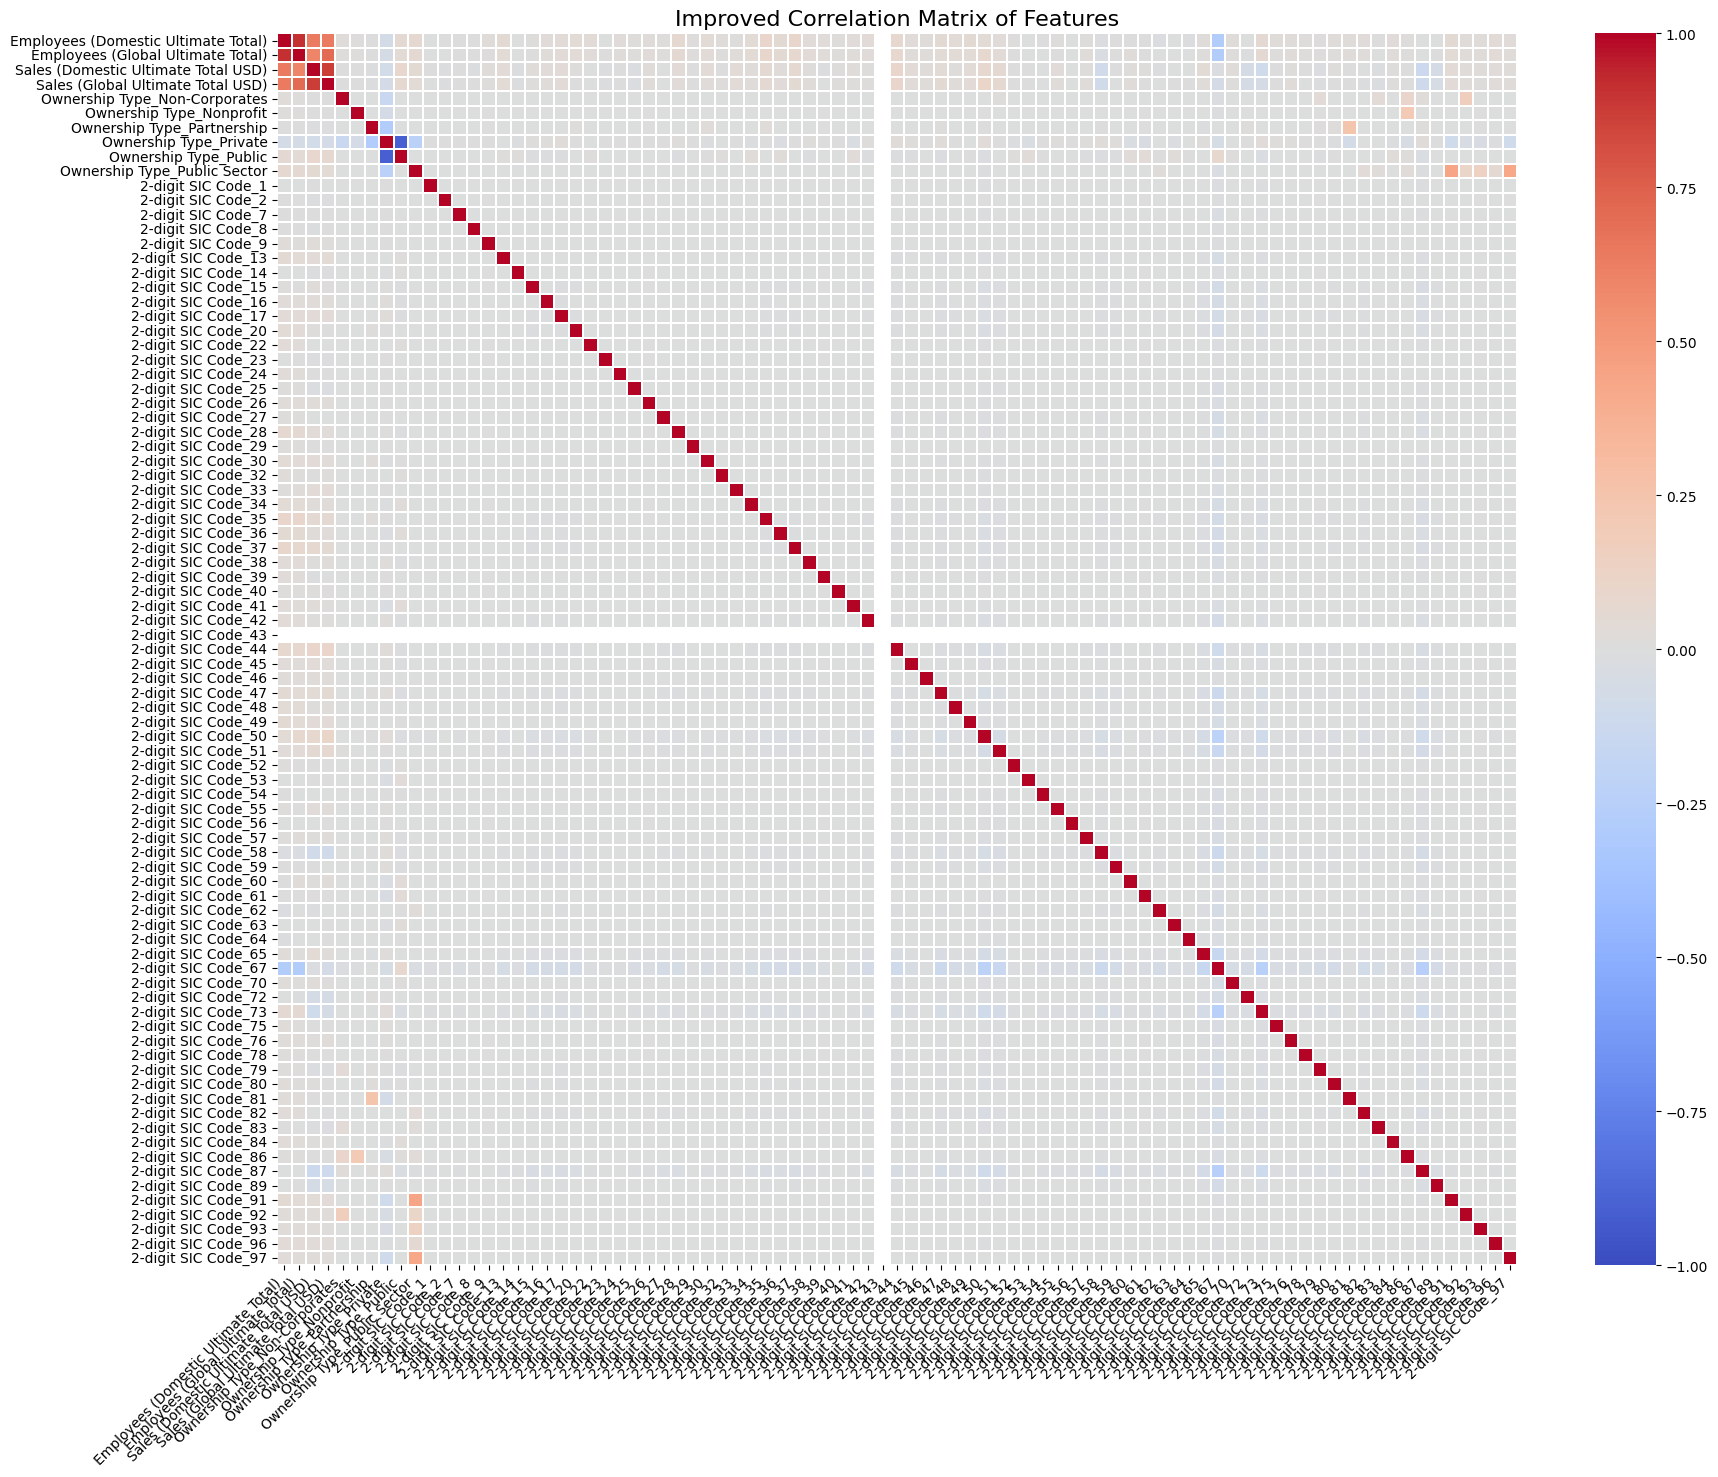

In [ ]:
plt.figure(figsize=(20, 16))  # Increase figure size

sns.heatmap(
    corr_matrix,
    annot=False,  # Set to True if you want to see the correlation values
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.1,
    vmin=-1, vmax=1,
    xticklabels=corr_matrix.columns,
    yticklabels=corr_matrix.columns
)

# Rotate labels
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

# Add title
plt.title("Improved Correlation Matrix of Features", fontsize=16)

plt.show()


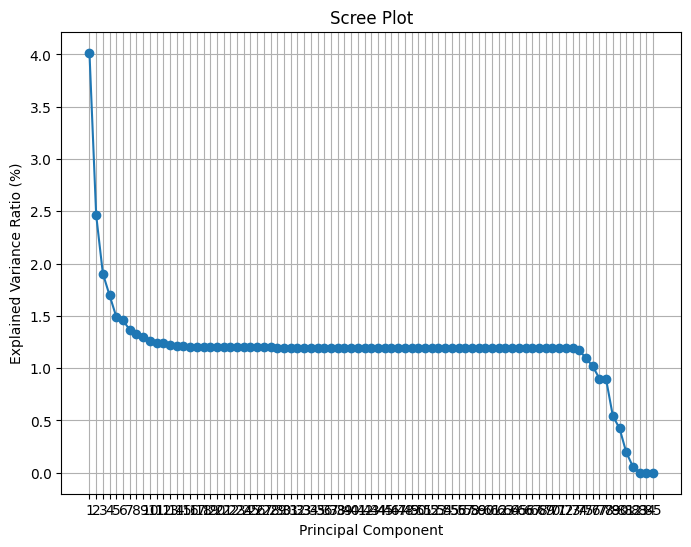

In [ ]:
pca = PCA()
X_pca = pca.fit_transform(X_scaled)
explained_variance = pca.explained_variance_ratio_

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance * 100, marker='o')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio (%)')
plt.xticks(range(1, len(explained_variance) + 1))
plt.grid(True)
plt.show()

Based on the Scree Plot, we identified that the elbow point occurred at the 7th Principal Component, leading us to explore the top contributing features for the first 7 PCs.

Viewing the contributing features, we decided to include the first 3 PCs, which explain about 8.4% of variance, into our model because they were the most interpretable.

PC1, which includes employee count and sales figures heavily, reflects our observations with the correlation matrix. We associate PC1 with the size of a company and its scale of operations, and we deem this as relevant to the hierarchy of a company.

PC2, also reflects our correlation matrix observations. It includes details on ownership type of a company.

PC3 appears to represent the company's degree of control upon other companies, which we believe is highly relevant to our analysis of company hierarchy. SIC 67xx includes holding companies, while SIC 91xx and 97xx are involved in governmental affairs and national security.



Top contributing features for each principal component:

Principal Component 1:
Employees (Global Ultimate Total)      0.487527
Employees (Domestic Ultimate Total)    0.483395
Sales (Global Ultimate Total USD)      0.476036
Sales (Domestic Ultimate Total USD)    0.459822
2-digit SIC Code_67                    0.150521
Name: PC1, dtype: float64

Principal Component 2:
Ownership Type_Private          0.653459
Ownership Type_Public           0.565429
Ownership Type_Public Sector    0.266115
Ownership Type_Partnership      0.189404
2-digit SIC Code_67             0.163747
Name: PC2, dtype: float64

Principal Component 3:
Ownership Type_Public Sector    0.632434
2-digit SIC Code_91             0.440947
2-digit SIC Code_97             0.423380
Ownership Type_Public           0.291762
2-digit SIC Code_67             0.191354
Name: PC3, dtype: float64

Principal Component 4:
2-digit SIC Code_67                    0.669523
2-digit SIC Code_87                    0.341124
2-digit SIC Code_73     

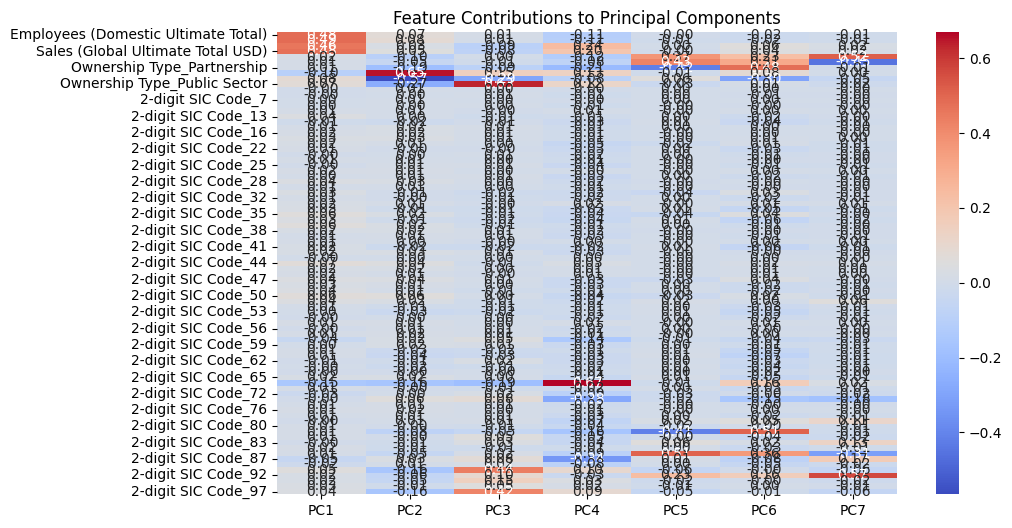

Year Found                             0
Employees (Domestic Ultimate Total)    0
Employees (Global Ultimate Total)      0
Sales (Domestic Ultimate Total USD)    0
Sales (Global Ultimate Total USD)      0
                                      ..
2-digit SIC Code_91                    0
2-digit SIC Code_92                    0
2-digit SIC Code_93                    0
2-digit SIC Code_96                    0
2-digit SIC Code_97                    0
Length: 88, dtype: int64

In [ ]:
pca = PCA(n_components=7)  # Select the first 7 principal components
X_pca = pca.fit_transform(X_scaled)

# Get component loadings (feature contributions to PCs)
loadings = pd.DataFrame(pca.components_.T, index=X.columns, columns=[f'PC{i+1}' for i in range(7)])

# Display the top features contributing to each principal component
print("Top contributing features for each principal component:")
for i in range(7):
    print(f"\nPrincipal Component {i+1}:")
    print(loadings.iloc[:, i].abs().sort_values(ascending=False).head(5))  # Top 5 most important features

# Plot the heatmap for feature contributions
plt.figure(figsize=(10, 6))
sns.heatmap(loadings, cmap='coolwarm', annot=True, fmt=".2f")
plt.title("Feature Contributions to Principal Components")
plt.show()

df.isna().sum()

In [ ]:
# Adding Principal Components to df
df_pca = pd.DataFrame(X_pca[:, :3], columns=[f'PC{i+1}' for i in range(3)])

# Reset indices
df_pca.reset_index(drop=True, inplace=True)
df.reset_index(drop=True, inplace=True)

# Concatenate the dataframes
df = pd.concat([df, df_pca], axis=1)

# Display the first few rows
df.head()

Year Found  Employees (Domestic Ultimate Total)  \
0      1993.0                             4.615121   
1      2018.0                             3.135494   
2      1986.0                             3.526361   
3      2008.0                             2.639057   
4      2006.0                             2.197225   

   Employees (Global Ultimate Total)  Sales (Domestic Ultimate Total USD)  \
0                           4.615121                            16.066724   
1                           3.135494                            16.435712   
2                           3.526361                            17.924147   
3                           2.639057                            13.138497   
4                           2.197225                            12.359862   

   Sales (Global Ultimate Total USD)  Is Domestic Ultimate  \
0                          16.066724                     0   
1                          16.435712                     0   
2                          17.924147                     1   
3                          13.138497                     0   
4                          12.359862                     0   

   Is Global Ultimate  Ownership Type_Non-Corporates  \
0                   0                            0.0   
1                   0                            0.0   
2                   1                            0.0   
3                   0                            0.0   
4                   0                            0.0   

   Ownership Type_Nonprofit  Ownership Type_Partnership  ...  \
0                       0.0                         0.0  ...   
1                       0.0                         0.0  ...   
2                       0.0                         0.0  ...   
3                       0.0                         0.0  ...   
4                       0.0                         0.0  ...   

   2-digit SIC Code_87  2-digit SIC Code_89  2-digit SIC Code_91  \
0                  0.0                  0.0                  0.0   
1                  0.0                  0.0                  0.0   
2                  0.0                  0.0                  0.0   
3                  0.0                  0.0                  0.0   
4                  0.0                  0.0                  0.0   

   2-digit SIC Code_92  2-digit SIC Code_93  2-digit SIC Code_96  \
0                  0.0                  0.0                  0.0   
1                  0.0                  0.0                  0.0   
2                  0.0                  0.0                  0.0   
3                  0.0                  0.0                  0.0   
4                  0.0                  0.0                  0.0   

   2-digit SIC Code_97       PC1       PC2       PC3  
0                  0.0  2.600046  0.293654 -0.465165  
1                  0.0  1.545816  0.102720 -0.530836  
2                  0.0  2.834285  0.235981 -0.697102  
3                  0.0 -0.947151  0.328711  0.536712  
4                  0.0 -1.827995  0.225277  0.620008  

[5 rows x 91 columns]

# Utilising newly-formed categories in Training and Testing of Supervised Learning Models
---



## Model Training
Using a 80/20 ratio, observations in the dataset were split into two segments: (1) ... obs. in train set for training purposes and (2) ... obs in test set for testing purposes, as reflective in the following codes for each Machine Learning method.

We will be training and testing two models to separately predict whether the company is Global or Local Ultimate, or both.

## Logistic Regression


Is Global Ultimate Class Distribution:
Is Global Ultimate
0    10298
1     6668
Name: count, dtype: int64

Is Global Ultimate - Model Accuracy: 66.26%
Classification Report for Is Global Ultimate:
              precision    recall  f1-score   support

           0       0.71      0.55      0.62      2060
           1       0.63      0.78      0.70      2060

    accuracy                           0.66      4120
   macro avg       0.67      0.66      0.66      4120
weighted avg       0.67      0.66      0.66      4120



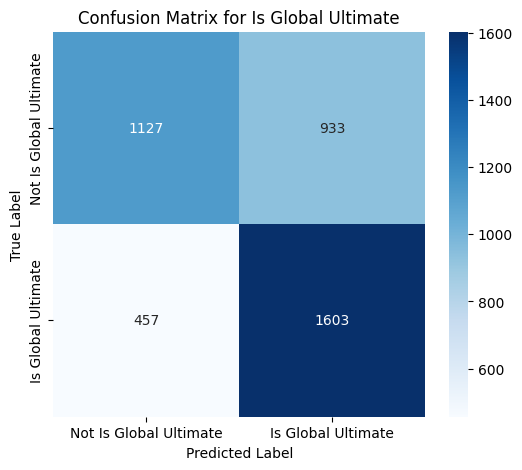

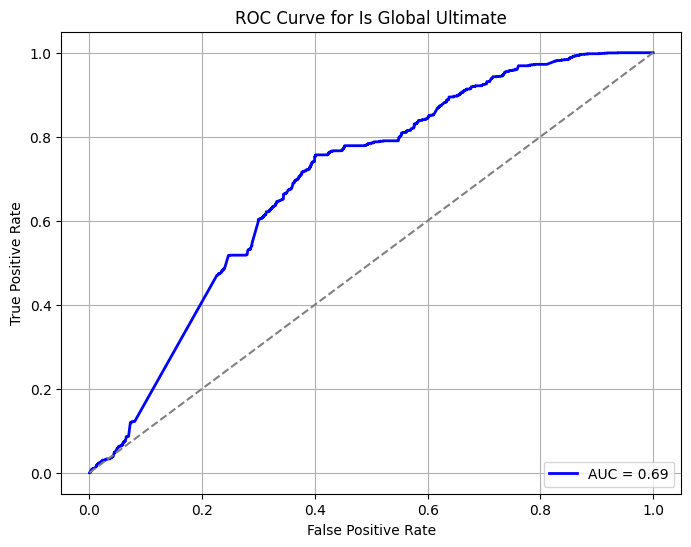

Is Domestic Ultimate Class Distribution:
Is Domestic Ultimate
0    9392
1    7574
Name: count, dtype: int64

Is Domestic Ultimate - Model Accuracy: 63.70%
Classification Report for Is Domestic Ultimate:
              precision    recall  f1-score   support

           0       0.68      0.65      0.66      1879
           1       0.59      0.63      0.61      1515

    accuracy                           0.64      3394
   macro avg       0.63      0.64      0.63      3394
weighted avg       0.64      0.64      0.64      3394



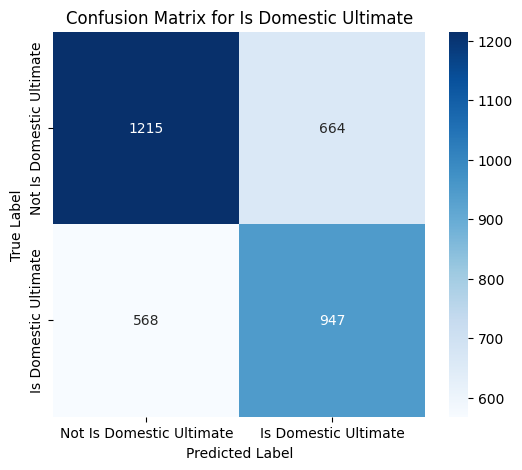

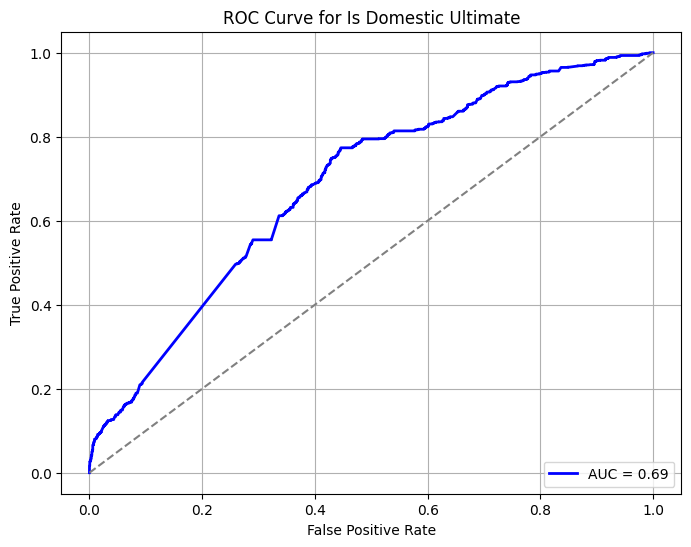

In [ ]:
def train_logistic_regression(X, y, target_name, apply_smote=False):
    # Check class balance
    class_counts = y.value_counts()
    print(f"{target_name} Class Distribution:\n{class_counts}\n")

    # Apply SMOTE only for "Is Global Ultimate"
    if apply_smote:
        smote = SMOTE(sampling_strategy='auto', random_state=42)
        X_resampled, y_resampled = smote.fit_resample(X, y)
    else:
        X_resampled, y_resampled = X, y

    # Split into train-test sets using resampled data
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

    # Initialize and standardize the features (scaling after resampling)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Initialize and train the Logistic Regression model
    model = LogisticRegression(random_state=42, max_iter=1000)
    model.fit(X_train_scaled, y_train)

    # Predictions
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]  # Get probability scores for positive class

    # Compute accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{target_name} - Model Accuracy: {accuracy * 100:.2f}%")

    # Classification Report
    print(f"Classification Report for {target_name}:\n{classification_report(y_test, y_pred)}")

    # Compute and display confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not " + target_name, target_name],
                yticklabels=["Not " + target_name, target_name])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix for {target_name}")
    plt.show()

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    # Plot ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal reference line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {target_name}')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    # Return trained model and metrics
    return model, accuracy

# Model 1: Predicting "Is Global Ultimate"
y_global = df['Is Global Ultimate']
log_model_global, acc_global = train_logistic_regression(X_scaled, y_global, "Is Global Ultimate", apply_smote=True)

# Model 2: Predicting "Is Domestic Ultimate"
y_domestic = df['Is Domestic Ultimate']
log_model_domestic, acc_domestic = train_logistic_regression(X_scaled, y_domestic, "Is Domestic Ultimate", apply_smote=False)


## Decision Tree

Is Global Ultimate Class Distribution:
Is Global Ultimate
0    10298
1     6668
Name: count, dtype: int64

Is Global Ultimate - Model Accuracy: 72.11%

Classification Report for Is Global Ultimate:
              precision    recall  f1-score   support

           0       0.87      0.52      0.65      2060
           1       0.66      0.92      0.77      2060

    accuracy                           0.72      4120
   macro avg       0.76      0.72      0.71      4120
weighted avg       0.76      0.72      0.71      4120



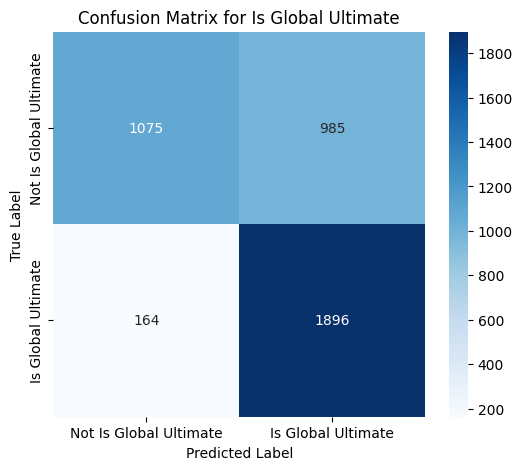

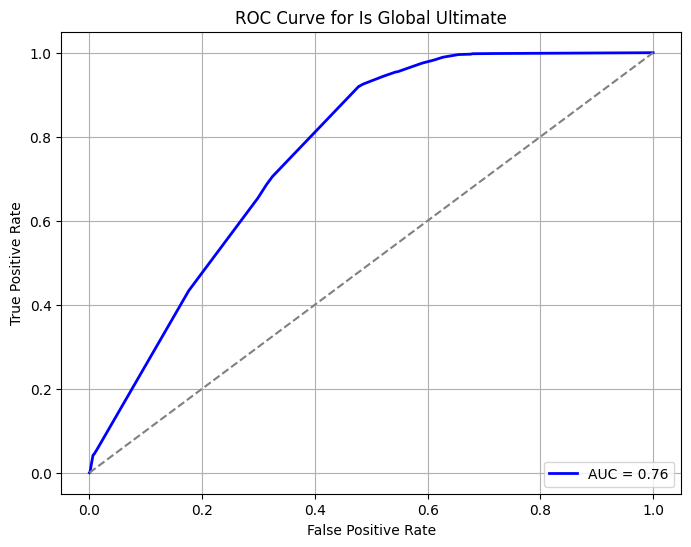

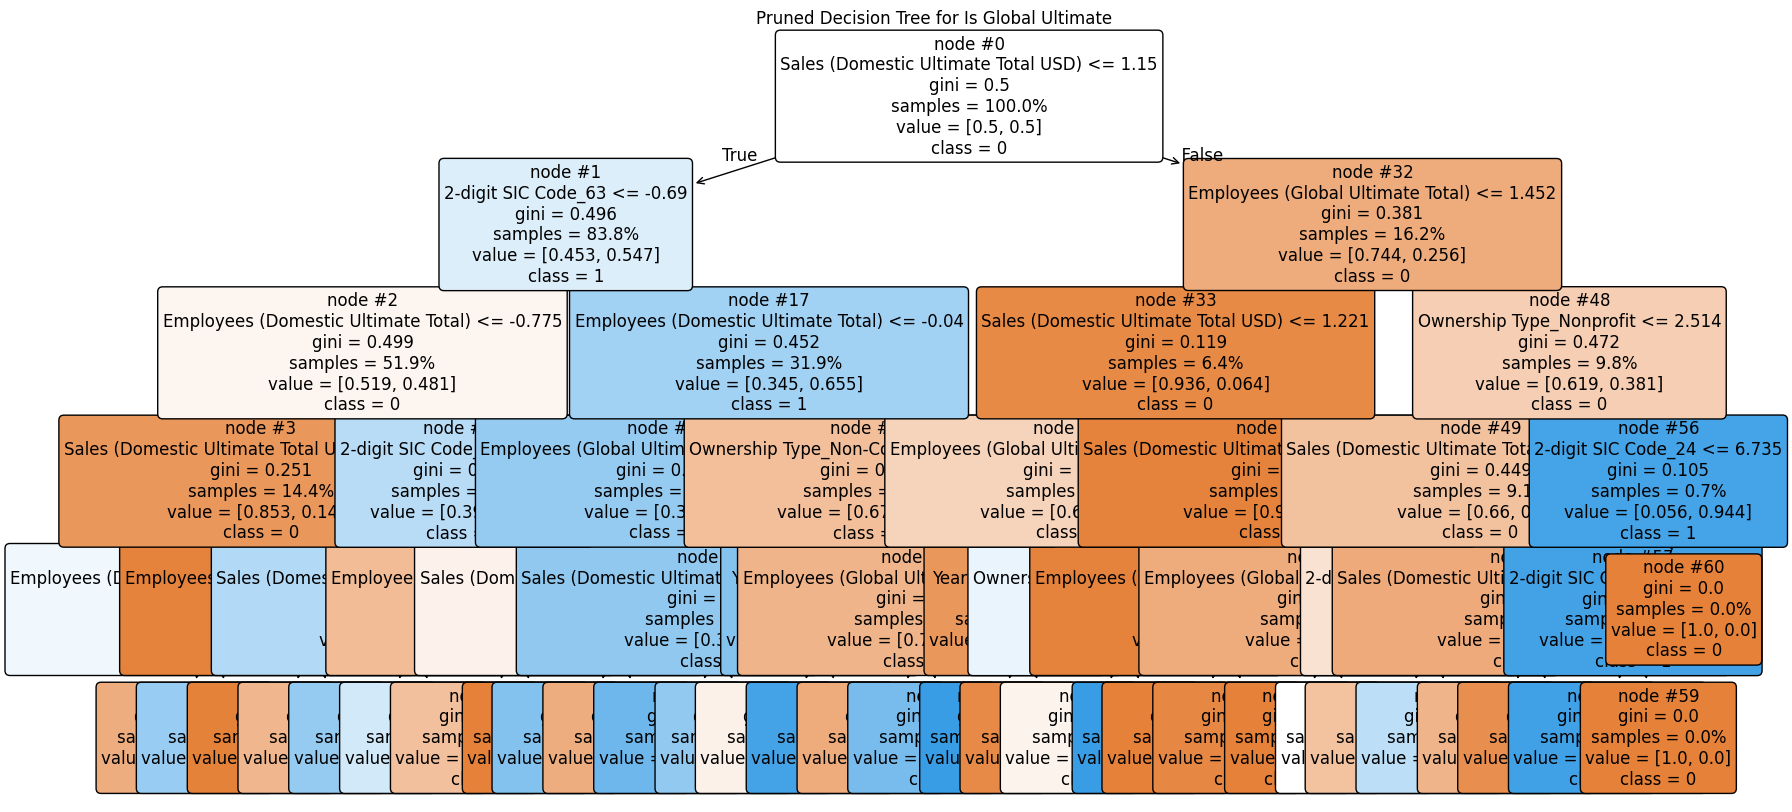

Is Domestic Ultimate Class Distribution:
Is Domestic Ultimate
0    9392
1    7574
Name: count, dtype: int64

Is Domestic Ultimate - Model Accuracy: 68.62%

Classification Report for Is Domestic Ultimate:
              precision    recall  f1-score   support

           0       0.86      0.51      0.64      1879
           1       0.60      0.90      0.72      1515

    accuracy                           0.69      3394
   macro avg       0.73      0.71      0.68      3394
weighted avg       0.75      0.69      0.68      3394



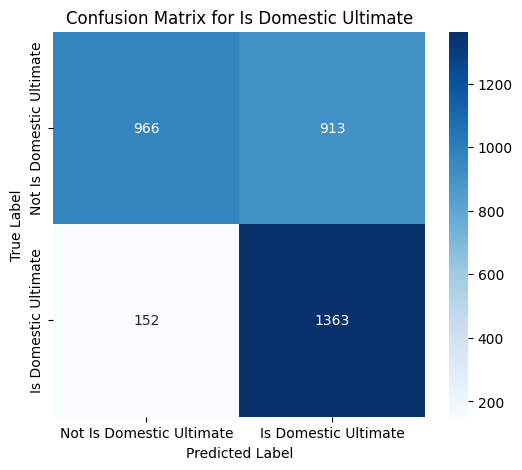

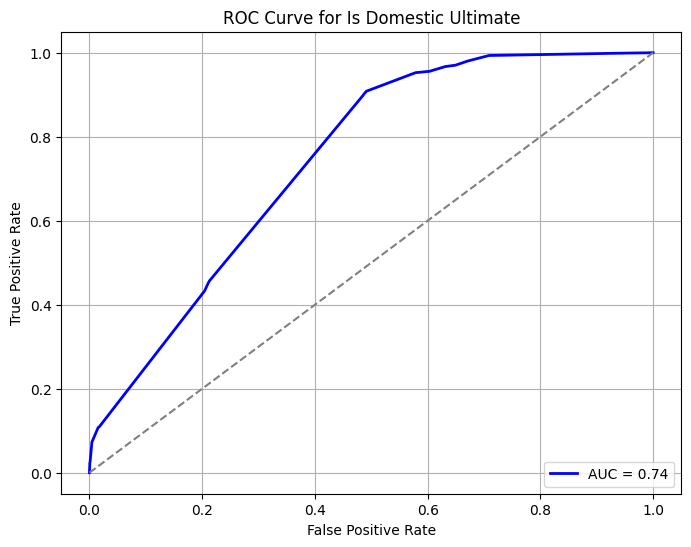

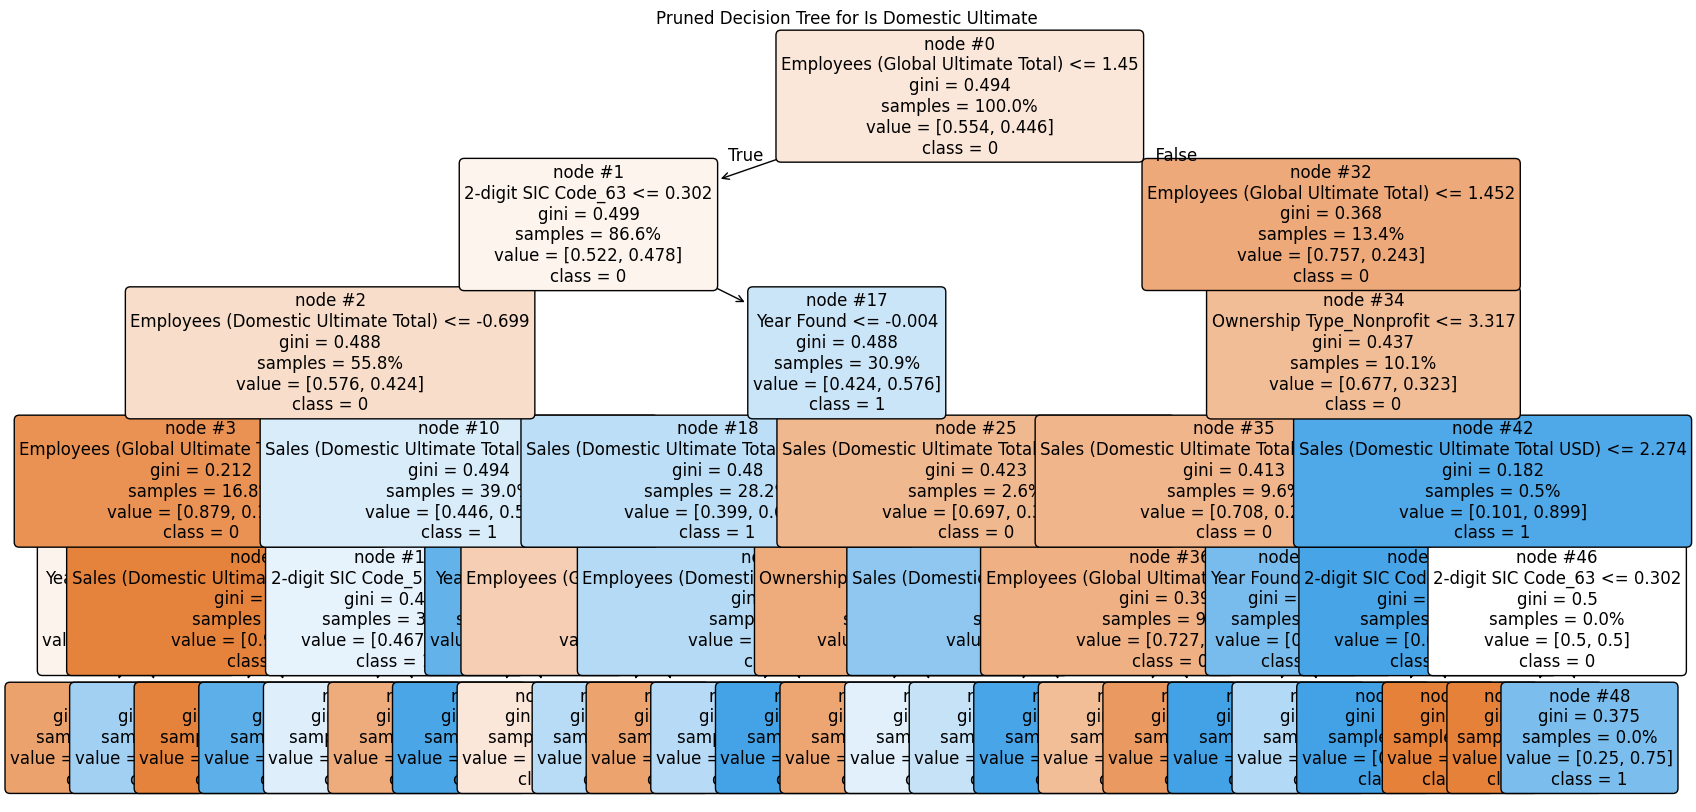

In [ ]:
def train_decision_tree(X, y, target_name, max_depth=5, apply_smote=False):

    # Check class balance
    class_counts = y.value_counts()
    print(f"{target_name} Class Distribution:\n{class_counts}\n")

    # Apply SMOTE if requested
    if apply_smote:
        smote = SMOTE(sampling_strategy='auto', random_state=42)
        X_resampled, y_resampled = smote.fit_resample(X, y)
    else:
        X_resampled, y_resampled = X, y

    # Split into train-test sets using resampled data
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

    # Initialize and train the Decision Tree Classifier with max_depth
    clf = DecisionTreeClassifier(random_state=42, max_depth=max_depth)
    clf.fit(X_train, y_train)

    # Predictions
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:, 1]  # Get probability scores for the positive class

    # Compute accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{target_name} - Model Accuracy: {accuracy * 100:.2f}%\n")

    # Classification Report
    print(f"Classification Report for {target_name}:\n{classification_report(y_test, y_pred)}")

    # Compute and display confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not " + target_name, target_name],
                yticklabels=["Not " + target_name, target_name])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix for {target_name}")
    plt.show()

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    # Plot ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal reference line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {target_name}')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    # Plot Decision Tree with black lines (pruned style)
    plt.figure(figsize=(20, 10))
    plot_tree(
        clf,
        filled=True,
        feature_names=df.columns,
        class_names=['0', '1'],
        rounded=True,
        fontsize=12,
        proportion=True,  # Make the decision tree more compact
        node_ids=True,  # Show node IDs
        label='all'  # Show labels for all nodes
    )

    plt.title(f"Pruned Decision Tree for {target_name}")
    plt.show()


    # Return trained model and metrics
    return clf, accuracy

# Model 1: Predicting "Is Global Ultimate"
y_global = df['Is Global Ultimate']
clf_global, acc_global = train_decision_tree(X_scaled, y_global, "Is Global Ultimate", max_depth=5, apply_smote=True)

# Model 2: Predicting "Is Domestic Ultimate"
y_domestic = df['Is Domestic Ultimate']
clf_domestic, acc_domestic = train_decision_tree(X_scaled, y_domestic, "Is Domestic Ultimate", max_depth=5, apply_smote=False)


Is Global Ultimate Class Distribution:
Is Global Ultimate
0    10298
1     6668
Name: count, dtype: int64

Is Global Ultimate - Model Accuracy: 71.17%

Classification Report for Is Global Ultimate:
              precision    recall  f1-score   support

           0       0.81      0.55      0.66      2060
           1       0.66      0.88      0.75      2060

    accuracy                           0.71      4120
   macro avg       0.74      0.71      0.70      4120
weighted avg       0.74      0.71      0.70      4120



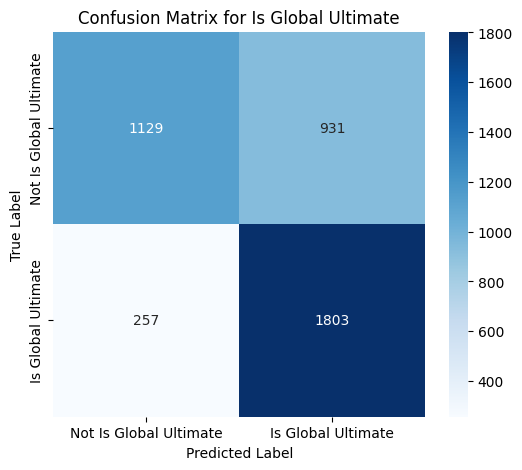

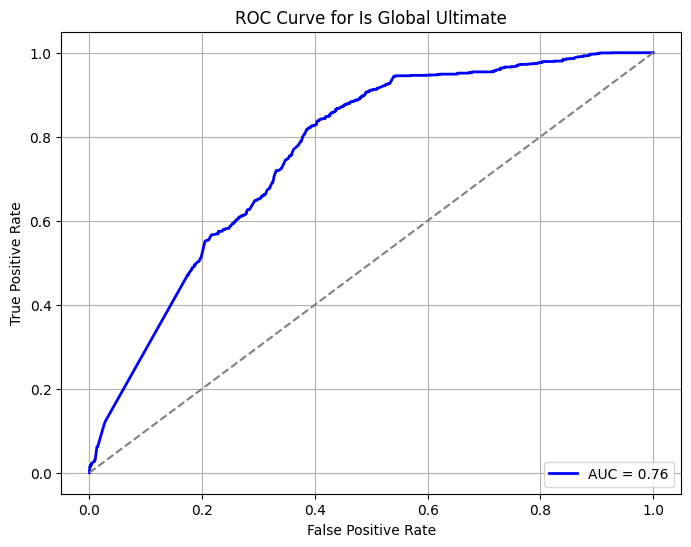

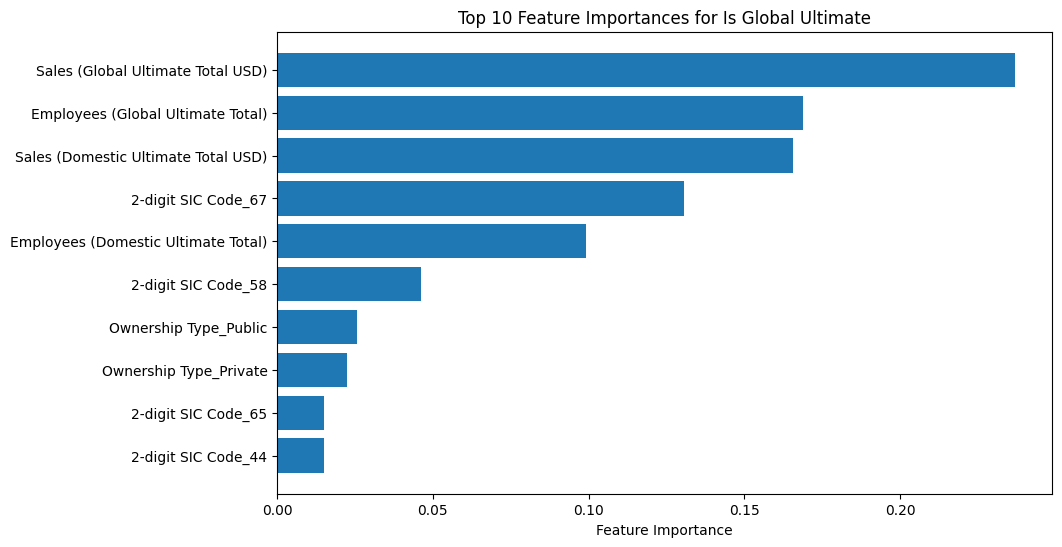

Is Domestic Ultimate Class Distribution:
Is Domestic Ultimate
0    9392
1    7574
Name: count, dtype: int64

Is Domestic Ultimate - Model Accuracy: 70.19%

Classification Report for Is Domestic Ultimate:
              precision    recall  f1-score   support

           0       0.79      0.55      0.65      1879
           1       0.66      0.85      0.74      1878

    accuracy                           0.70      3757
   macro avg       0.72      0.70      0.70      3757
weighted avg       0.72      0.70      0.70      3757



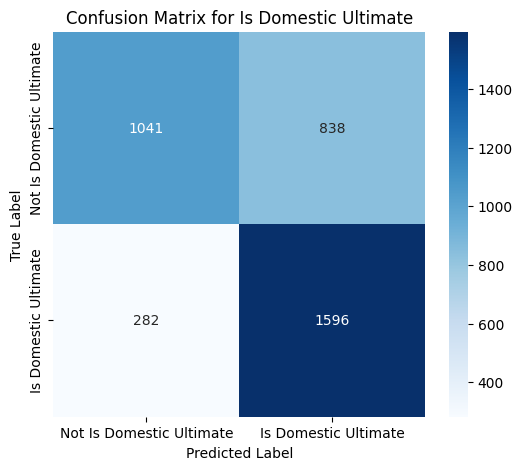

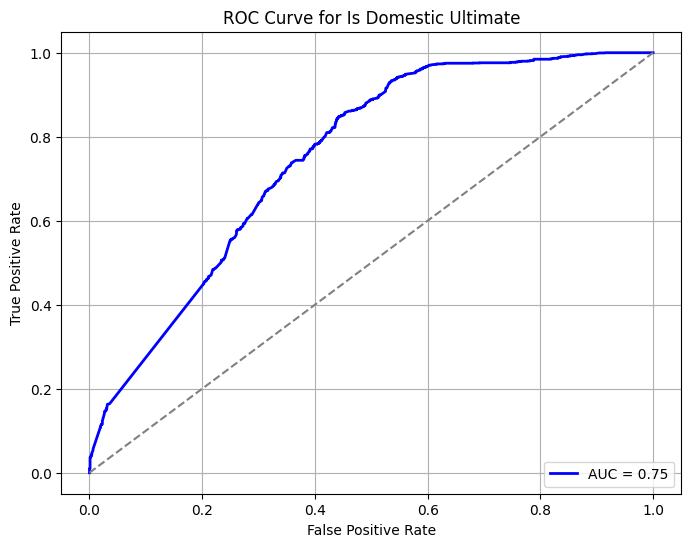

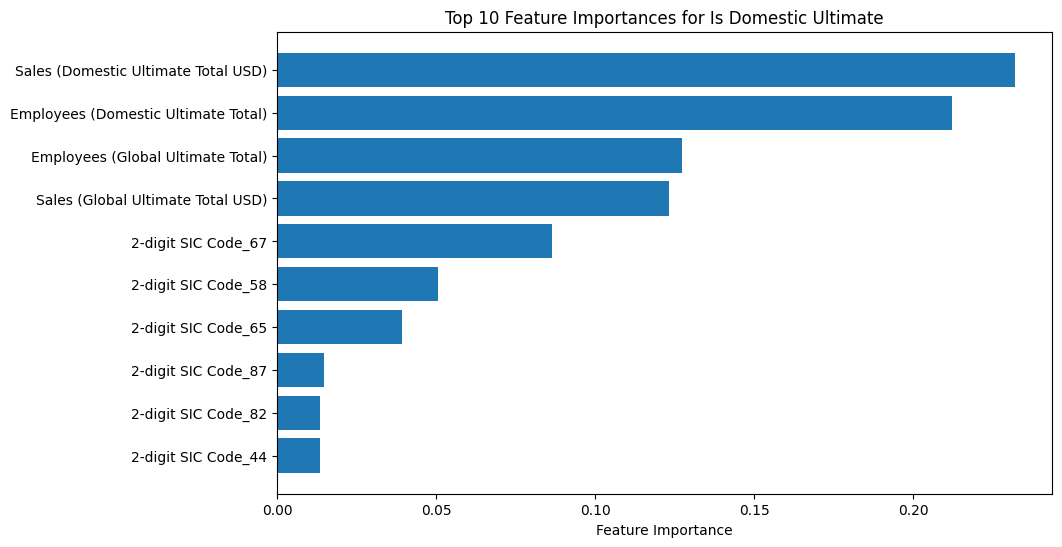

In [ ]:
def train_random_forest(X, y, target_name, max_depth=5, n_estimators=100, apply_smote=False, feature_names=None):

    # Check class balance
    class_counts = y.value_counts()
    print(f"{target_name} Class Distribution:\n{class_counts}\n")

    # Apply SMOTE if requested
    if apply_smote:
        smote = SMOTE(sampling_strategy='auto', random_state=42)
        X_resampled, y_resampled = smote.fit_resample(X, y)  # X is the original DataFrame
    else:
        X_resampled, y_resampled = X, y

    # Split into train-test sets using resampled data
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

    # Initialize and train the Random Forest Classifier
    rf = RandomForestClassifier(random_state=42, max_depth=max_depth, n_estimators=n_estimators)
    rf.fit(X_train, y_train)

    # Predictions
    y_pred = rf.predict(X_test)
    y_prob = rf.predict_proba(X_test)[:, 1]  # Get probability scores for the positive class

    # Compute accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{target_name} - Model Accuracy: {accuracy * 100:.2f}%\n")

    # Classification Report
    print(f"Classification Report for {target_name}:\n{classification_report(y_test, y_pred)}")

    # Compute and display confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not " + target_name, target_name],
                yticklabels=["Not " + target_name, target_name])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix for {target_name}")
    plt.show()

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    # Plot ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal reference line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {target_name}')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    # Plot Random Forest feature importances (top 10)
    feature_importances = rf.feature_importances_
    sorted_idx = feature_importances.argsort()[-10:]  # Get the indices of the top 10 features
    sorted_importances = feature_importances[sorted_idx]

    plt.figure(figsize=(10, 6))
    plt.barh(range(len(sorted_idx)), sorted_importances, align='center')
    plt.yticks(range(len(sorted_idx)), feature_names[sorted_idx])
    plt.xlabel('Feature Importance')
    plt.title(f'Top 10 Feature Importances for {target_name}')
    plt.show()

    # Return trained model and metrics
    return rf, accuracy

# Create a copy of the feature names before scaling
feature_names = X.columns

# Target variable: "Is Global Ultimate"
y_global = df['Is Global Ultimate']

# Train the Random Forest model for "Is Global Ultimate" with SMOTE
rf_global, acc_global = train_random_forest(X_scaled, y_global, "Is Global Ultimate", max_depth=5, apply_smote=True, feature_names=feature_names)

# Optionally, if you'd like to train for "Is Domestic Ultimate" as well
y_domestic = df['Is Domestic Ultimate']
rf_domestic, acc_domestic = train_random_forest(X_scaled, y_domestic, "Is Domestic Ultimate", max_depth=5, apply_smote=True, feature_names=feature_names)



## Neural Network (Chosen Model)

Our last attempt uses neural networks to classify entries as Domestic Ultimate or Global Ultimate using TensorFlow and Keras. The goal is to predict these binary outcomes based on the provided features using two separate neural network architectures.

We created an initial model with build_neural_network with 3 layers:

Input Layer with 64 neurons (ReLU activation)

Hidden Layer with 32 neurons (ReLU activation)

Output Layer with 1 neuron (Sigmoid activation for binary classification)


After experimenting with model architecture and further finetuning, we found that an additional hidden layer improved prediction power significantly, and thus we improved neural network model performance with build_neural_network_v4 which includes 4 layers:


Input Layer with 64 neurons (ReLU activation)

Two Hidden Layers with 32 and 16 neurons (ReLU activation)

Output Layer with 1 neuron (Sigmoid activation)

The train_and_evaluate function performs the following steps:

Early Stopping: Monitors validation loss and stops training if no improvement is detected for 10 consecutive epochs.

Training: The model is trained for up to 100 epochs with a batch size of 32.

Evaluation: The model's performance is evaluated using test data.

We used accuracy and loss curves, a confusion matrix, and an ROC curve to visualise model performance. We noted that v4 showed improvements across most metrics.

In [ ]:
# Load your DataFrame (replace 'your_dataframe' with the actual DataFrame)
# df = your_dataframe

# Define target variables
target_domestic = 'Is Domestic Ultimate'
target_global = 'Is Global Ultimate'

# Split features and targets
X = df.drop(columns=[target_domestic, target_global])
y_domestic = df[target_domestic]
y_global = df[target_global]

# Split into train and test sets (80/20 split)
X_train, X_test, y_train_dom, y_test_dom = train_test_split(X, y_domestic, test_size=0.2, random_state=42)
_, _, y_train_glob, y_test_glob = train_test_split(X, y_global, test_size=0.2, random_state=42)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
def build_neural_network(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(input_shape,)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

def build_neural_network_v4(input_shape):
    from tensorflow.keras import layers

    model = tf.keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=(input_shape,)),
        layers.Dense(32, activation='relu'),
        layers.Dense(16, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
# Set random seeds for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

def train_and_evaluate(model, X_train, y_train, X_test, y_test, model_name):
    from tensorflow.keras.callbacks import EarlyStopping

    # Early stopping to avoid overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train the model
    history = model.fit(X_train, y_train,
                        epochs=100,
                        batch_size=32,
                        validation_split=0.2,
                        callbacks=[early_stopping],
                        verbose=1)

    # Evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f"\n{model_name} Test Accuracy: {accuracy:.3f}")

    # Plot accuracy and loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{model_name} Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Generate and display confusion matrix
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

    # Compute ROC curve and AUC
    y_prob = model.predict(X_test)  # This will be a single column for binary classification
    if y_prob.shape[1] == 1:
        # In case of binary classification, y_prob is a 1D array with probabilities for the positive class
        y_prob = y_prob.flatten()  # Convert to 1D array

    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal reference line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


340/340 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6151 - loss: 0.6610 - val_accuracy: 0.6913 - val_loss: 0.5942
Epoch 2/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6944 - loss: 0.5885 - val_accuracy: 0.6983 - val_loss: 0.5703
Epoch 3/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7109 - loss: 0.5615 - val_accuracy: 0.7098 - val_loss: 0.5582
Epoch 4/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7202 - loss: 0.5460 - val_accuracy: 0.7157 - val_loss: 0.5513
Epoch 5/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7237 - loss: 0.5366 - val_accuracy: 0.7223 - val_loss: 0.5459
Epoch 6/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7274 - loss: 0.5292 - val_accuracy: 0.7241 - val_loss: 0.5420
Epoch 7/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7305 - loss: 0.5234 - val_accuracy: 0.7260 - val_loss: 0.5393
Epoch 8/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7318 - loss: 0.5193 - val_accuracy: 0.7289

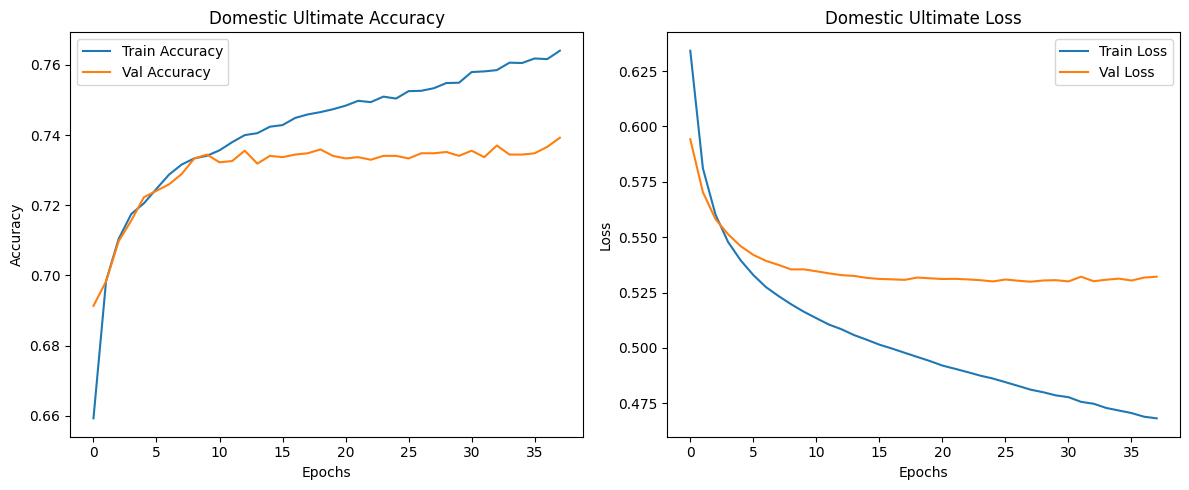

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


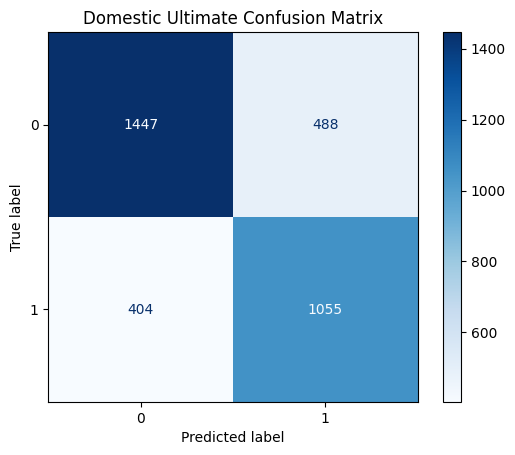

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


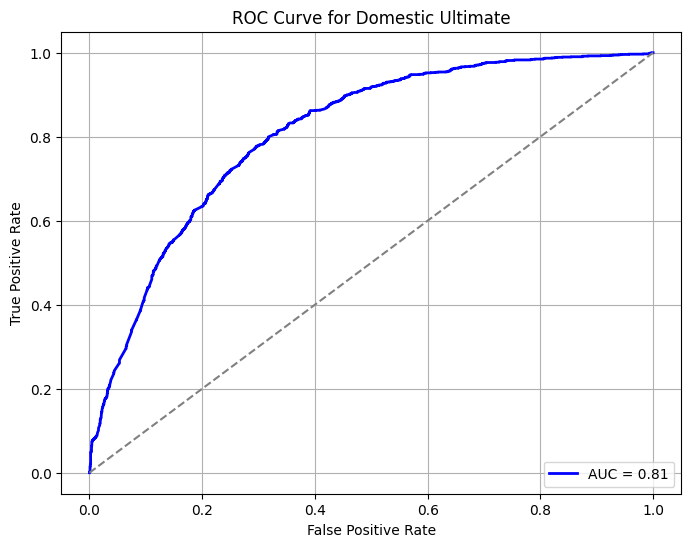

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


340/340 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6412 - loss: 0.6363 - val_accuracy: 0.7072 - val_loss: 0.5776
Epoch 2/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7059 - loss: 0.5712 - val_accuracy: 0.7109 - val_loss: 0.5555
Epoch 3/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7212 - loss: 0.5450 - val_accuracy: 0.7219 - val_loss: 0.5422
Epoch 4/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7295 - loss: 0.5295 - val_accuracy: 0.7274 - val_loss: 0.5345
Epoch 5/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7370 - loss: 0.5187 - val_accuracy: 0.7370 - val_loss: 0.5278
Epoch 6/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7417 - loss: 0.5099 - val_accuracy: 0.7433 - val_loss: 0.5235
Epoch 7/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7448 - loss: 0.5028 - val_accuracy: 0.7400 - val_loss: 0.5213
Epoch 8/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7457 - loss: 0.4973 - val_accuracy: 0.7444

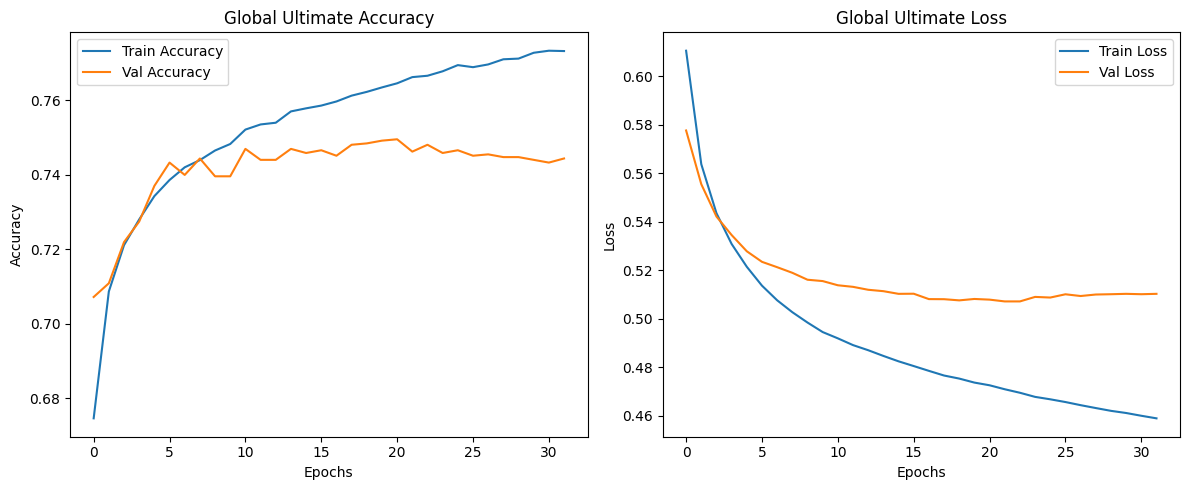

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


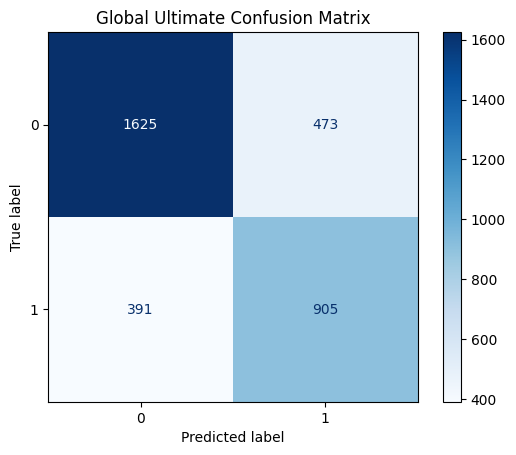

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


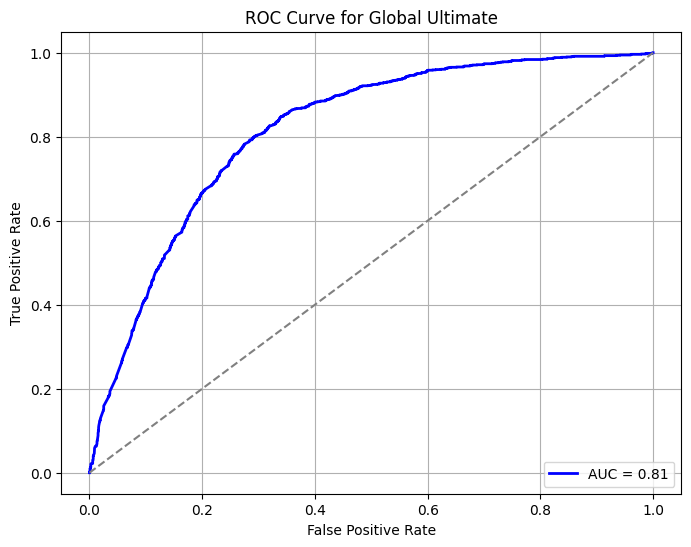

In [ ]:
# Train and evaluate for Domestic Ultimate
set_seed()
train_and_evaluate(build_neural_network(X_train_scaled.shape[1]),
                   X_train_scaled, y_train_dom, X_test_scaled, y_test_dom,
                   "Domestic Ultimate")

# Train and evaluate for Global Ultimate
set_seed()
train_and_evaluate(build_neural_network(X_train_scaled.shape[1]),
                   X_train_scaled, y_train_glob, X_test_scaled, y_test_glob,
                   "Global Ultimate")

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


340/340 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6174 - loss: 0.6614 - val_accuracy: 0.6939 - val_loss: 0.5911
Epoch 2/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6992 - loss: 0.5853 - val_accuracy: 0.7028 - val_loss: 0.5628
Epoch 3/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7106 - loss: 0.5528 - val_accuracy: 0.7098 - val_loss: 0.5522
Epoch 4/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7189 - loss: 0.5376 - val_accuracy: 0.7186 - val_loss: 0.5463
Epoch 5/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7261 - loss: 0.5286 - val_accuracy: 0.7238 - val_loss: 0.5424
Epoch 6/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7245 - loss: 0.5230 - val_accuracy: 0.7230 - val_loss: 0.5415
Epoch 7/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7304 - loss: 0.5180 - val_accuracy: 0.7260 - val_loss: 0.5393
Epoch 8/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7319 - loss: 0.5144 - val_accuracy: 0.7256

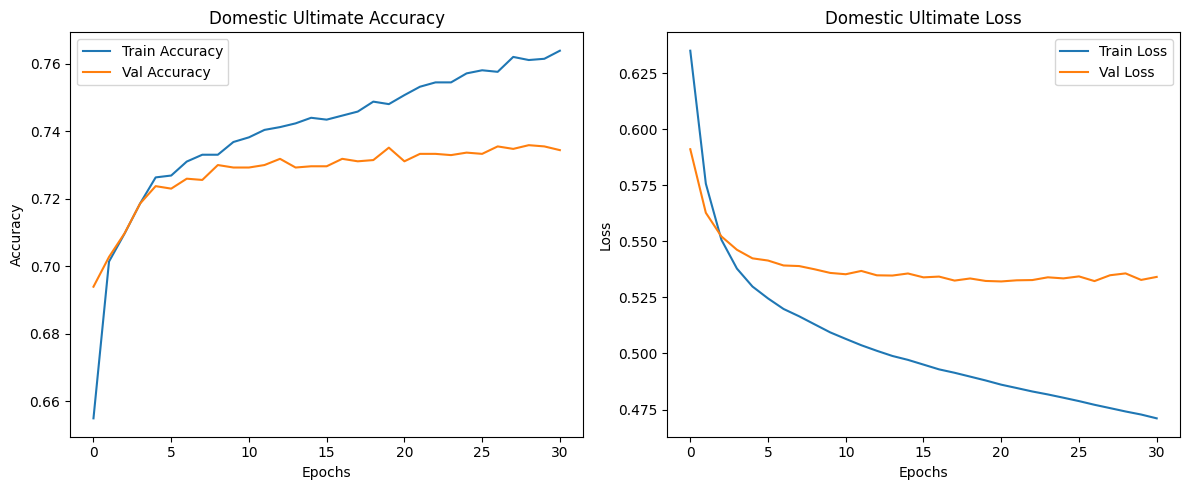

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


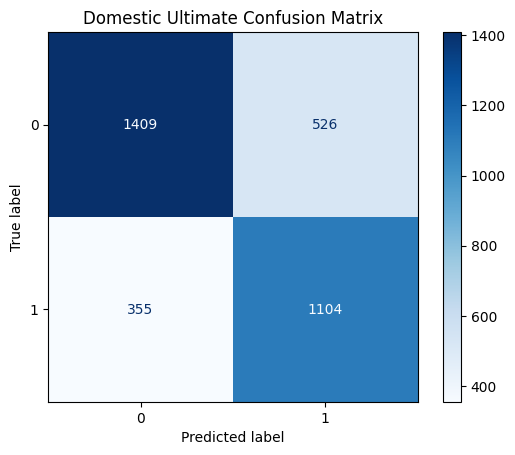

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


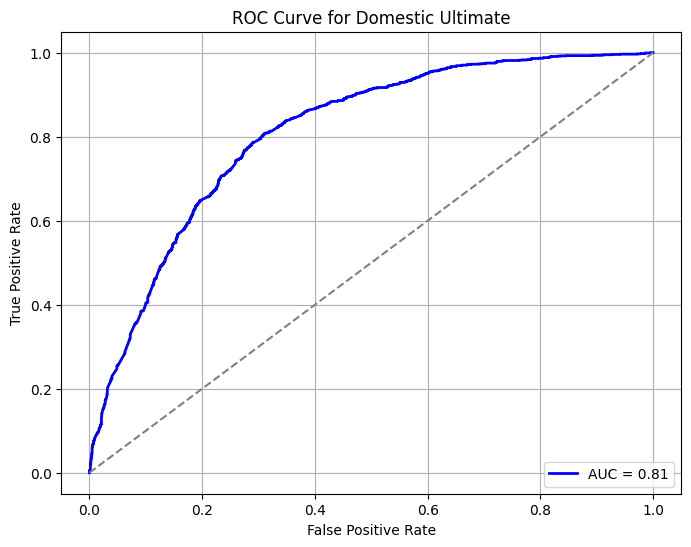

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


340/340 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6471 - loss: 0.6391 - val_accuracy: 0.6998 - val_loss: 0.5791
Epoch 2/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7088 - loss: 0.5723 - val_accuracy: 0.7230 - val_loss: 0.5485
Epoch 3/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7254 - loss: 0.5409 - val_accuracy: 0.7297 - val_loss: 0.5340
Epoch 4/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7335 - loss: 0.5229 - val_accuracy: 0.7392 - val_loss: 0.5258
Epoch 5/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7380 - loss: 0.5115 - val_accuracy: 0.7370 - val_loss: 0.5226
Epoch 6/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7406 - loss: 0.5025 - val_accuracy: 0.7411 - val_loss: 0.5208
Epoch 7/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7462 - loss: 0.4966 - val_accuracy: 0.7433 - val_loss: 0.5172
Epoch 8/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7468 - loss: 0.4912 - val_accuracy: 0.7429

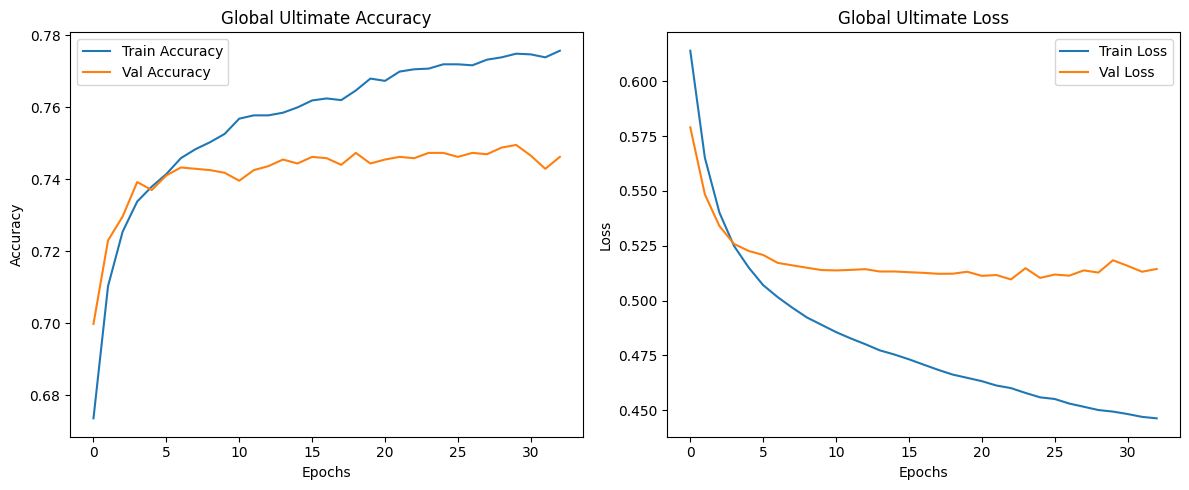

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


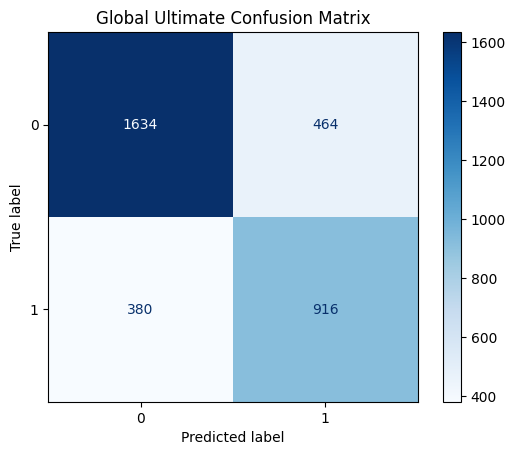

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


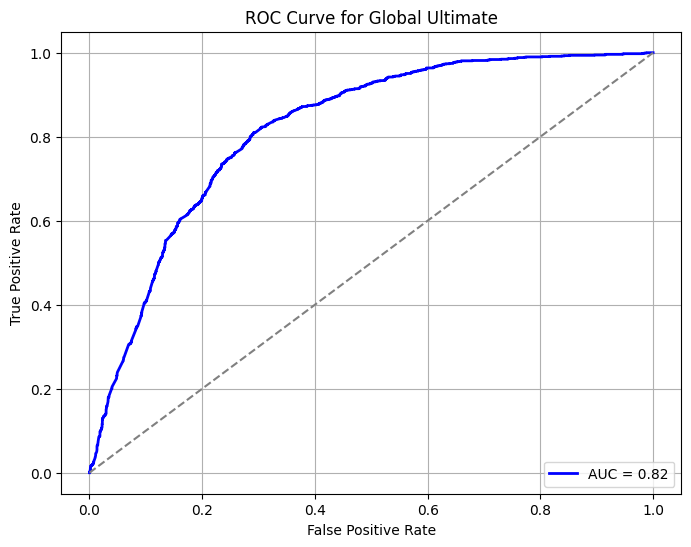

In [ ]:
# Train and evaluate for Domestic Ultimate
set_seed()
train_and_evaluate(build_neural_network_v4(X_train_scaled.shape[1]),
                   X_train_scaled, y_train_dom, X_test_scaled, y_test_dom,
                   "Domestic Ultimate")

# Train and evaluate for Global Ultimate
set_seed()
train_and_evaluate(build_neural_network_v4(X_train_scaled.shape[1]),
                   X_train_scaled, y_train_glob, X_test_scaled, y_test_glob,
                   "Global Ultimate")

# Model Evaluation


The following table shows a summary of performance of the respective model's predictions on test data.

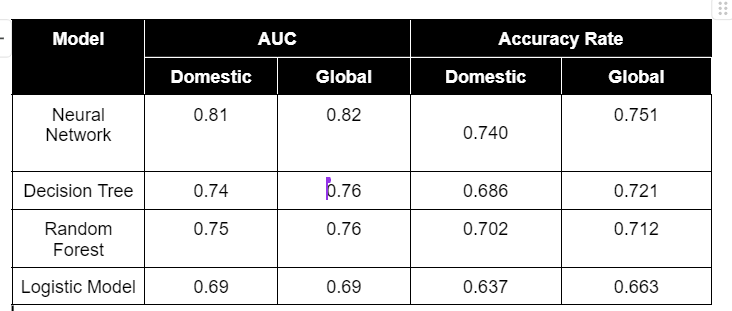

The final Build Neural network model achieved an accuracy of 0.740 for the domestic domain and 0.751 for the global ultimate resolution, representing a notable improvement over the initial model's accuracies of 0.737 and 0.745, respectively. Compared to other models, the neural network outperformed both the random forest, which had accuracies of 0.702 and 0.712, and the decision tree, which achieved accuracies of 0.686 and 0.721. Logistic regression showed the lowest performance, with accuracies of 0.637 and 0.663 for the domestic and global ultimate resolutions, respectively. These results indicate that the neural network model provides the best predictive performance across the evaluated domains.


# Conclusion


This project successfully developed a robust machine learning model to predict the "Is Domestic Ultimate" and "Is Global Ultimate" classifications for companies based on their operational, financial, and structural characteristics. By leveraging advanced data preprocessing, feature engineering, and model optimization techniques, we achieved accurate and reliable predictions that provide valuable insights into corporate ownership structures.

Our analysis highlighted the significance of key factors such as employee count, revenue, and industry classification in determining a company's hierarchical position. The use of ensemble learning methods, particularly XGBoost, proved to be highly effective in handling the complexity of the dataset while maintaining strong predictive performance. Additionally, addressing class imbalance and optimizing hyperparameters enhanced the model’s generalization capabilities.

These findings have practical implications for investors, regulators, and business strategists seeking to assess corporate autonomy and influence. Future work can explore deep learning models and additional data sources to refine the predictions further, ensuring greater accuracy and adaptability to evolving corporate structures. This study underscores the power of machine learning in transforming corporate analysis, offering a scalable and data-driven approach to understanding global business networks.
